<a href="https://colab.research.google.com/github/BenRoche18/Im2Calories/blob/master/food_classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import copy
import shutil
from PIL import Image
from tqdm.autonotebook import tqdm
import sys

**Import utility functions from Pytorch**

In [2]:
ROOT_DIR = os.path.dirname(os.getcwd())

sys.path.append(os.path.join(ROOT_DIR, "utilities"))

from engine import train_one_epoch, evaluate
import utils

**Enable GPU**

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


**Declare parameters**

In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 1

# Input data

**Fetch condensed classes from text file**

In [5]:
FOOD256_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food256")
CONDENSED_CLASSES_PATH = os.path.join(FOOD256_DIR, "condensed-category.txt")

with open(CONDENSED_CLASSES_PATH, 'r') as file:
    file.readline()
    classes = {line.split('\t')[0]:line.split('\t')[1].strip() for line in file.readlines()}

**Extract condensed classes from dataset**

Extract images and labels that correspond to condensed dataset and relabel classes so they are incremented by 1.

In [6]:
IMAGES_DIR = os.path.join(FOOD256_DIR, "condensed images")
LABELS_DIR = os.path.join(FOOD256_DIR, "condensed labels")

if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)
    os.makedirs(LABELS_DIR)

    for class_id in classes.keys():
        class_path = os.path.join(FOOD256_DIR, class_id, "bb_info.txt")
        
        # normalise class_id to determine new label
        lbl = str(list(classes.keys()).index(class_id) + 1)
            
        with open(class_path, 'r') as file:
            # ignore headers
            file.readline()
            
            for line in file.readlines():
                line = line.strip().split()
                img_path = os.path.join(FOOD256_DIR, class_id, line[0]+".jpg")

                # copy img to images directory
                dest = os.path.join(IMAGES_DIR, line[0]+".jpg")
                shutil.copy(img_path, dest)

                 # copy bounding box annotation into txt file in labels directory
                with open(os.path.join(LABELS_DIR, line[0]+".txt"), 'w') as box_file:
                    box = lbl + " " + " ".join(line[1:])
                    box_file.write(box)

**Define FoodDataset class as subclass of Dataset**

In [7]:
class CondensedFoodDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = list(sorted(os.listdir(os.path.join(root, "condensed images"))))
        self.classes = []
        with open(os.path.join(root, "condensed-category.txt"), 'r') as file:
            file.readline()
            for line in file.readlines():
                self.classes.append(line.strip().split("\t")[1])
        
    def __getitem__(self, index):
        # image
        img_path = os.path.join(self.root, "condensed images", self.images[index])
        img = Image.open(img_path).convert("RGB")
        
        #label
        lbl_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
        with open(lbl_path, 'r') as file:
            line = file.read().split()
            
        lbl = int(line[0]) - 1
            
        x1 = float(line[1])
        y1 = float(line[2])
        x2 = float(line[3])
        y2 = float(line[4])

        target = {
            "image_id": torch.as_tensor([index]),
            "labels": torch.as_tensor([lbl], dtype=torch.int64),
            "boxes": torch.as_tensor([[x1, y1, x2, y2]], dtype=torch.float32),
            "area": torch.as_tensor([(x2-x1)*(y2-y1)]),
            "iscrowd": torch.as_tensor([0], dtype=torch.int64)
        }
        
        if self.transform is not None:
            img, target = self.transform(img, target)
            
        return img, target
        
    
    def __len__(self):
        return len(self.images)

**Format images**

In [8]:
# custom transform for R-CNN input
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self, img, target):
        # resize to a max of IMAGE_SIZE
        w, h = img.size
        scale = min(IMAGE_SIZE/w, IMAGE_SIZE/h)
        img = transforms.functional.resize(img, (int(h*scale), int(w*scale)))
        
        # update bounding boxes
        target["boxes"] *= scale
        
        # add padding to a size of IMAGE_SIZE
        img = transforms.functional.pad(img, (0, 0, IMAGE_SIZE-int(w*scale), IMAGE_SIZE-int(h*scale)))
        
        # convert to tensor
        img = transforms.functional.to_tensor(img)

        # normalize
        img = img / 255
        return img, target

transform = CustomTransform(image_size=IMAGE_SIZE)

food_raw = CondensedFoodDataset(FOOD256_DIR, transform=transform)
food_size = len(food_raw)

class_names = food_raw.classes

**Split dataset into train and val sets**

In [9]:
indices = torch.randperm(food_size).tolist()

# define how to batch data (i.e not combine target dicitonaries)
def collate_fn(batch):
    return tuple(zip(*batch))

# take 80% as training
train_raw = torch.utils.data.Subset(food_raw, indices[:int(0.8*food_size)])
train_size = len(train_raw)
train_loader = torch.utils.data.DataLoader(train_raw, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# take 20% as validation
val_raw = torch.utils.data.Subset(food_raw, indices[int(0.8*food_size):])
val_size = len(val_raw)
val_loader = torch.utils.data.DataLoader(val_raw, batch_size=max(1, BATCH_SIZE//2), shuffle=True, collate_fn=collate_fn)

**Show example image with bounding boxes**

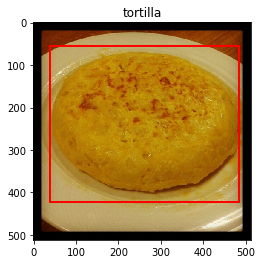

In [10]:
fig, axis= plt.subplots(1)

#randomly select image from dataset
i = np.random.randint(train_size)
img = train_raw[i][0].numpy()
img = np.transpose(img, (1,2,0))
img = img * 255
img = np.clip(img, 0, 1)
plt.imshow(img)

# draw bounding box
x1, y1, x2, y2 = train_raw[i][1]["boxes"][0]
box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
axis.add_patch(box)

plt.title(class_names[train_raw[i][1]["labels"][0]])

fig

# Model

**Fetch pretrained wide resnet on food101 dataset as backbone**

In [11]:
BACKBONE_PATH = os.path.join(ROOT_DIR, "models", "food_classification", "fine_tuning_wideres.pt")

print("Fetching pretrained backbone... ", end="")
backbone = torchvision.models.wide_resnet101_2(pretrained=False)

# replace classification head
num_features = backbone.fc.in_features
backbone.fc = torch.nn.Linear(num_features, 101)

# load trained weights
backbone.load_state_dict(torch.load(BACKBONE_PATH))

# remove classification head
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 2048

print("done")

Fetching pretrained backbone... done


**Create Faster R-CNN from wide resnet backbone**

In [12]:
print("Creating R-CNN... ", end="")
anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

model = torchvision.models.detection.FasterRCNN(backbone, num_classes=len(class_names), rpn_anchor_generator=anchor_generator)

model = model.to(device)
print("done") 

Creating R-CNN... done


# Train

**Declare optimizer**

In [13]:
learning_rate = 0.01

# fetch trainable parameters for transfer learning(where requires_grad = true)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=learning_rate)

**Train model**

In [14]:
num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    evaluate(model, val_loader, device)


Epoch: [0]  [   0/7346]  eta: 3:50:21  lr: 0.000020  loss: 5.1114 (5.1114)  loss_classifier: 4.3200 (4.3200)  loss_box_reg: 0.0427 (0.0427)  loss_objectness: 0.6993 (0.6993)  loss_rpn_box_reg: 0.0494 (0.0494)  time: 1.8815  data: 0.0582  max mem: 4257
Epoch: [0]  [  10/7346]  eta: 1:19:20  lr: 0.000120  loss: 5.0394 (5.0508)  loss_classifier: 4.2769 (4.2684)  loss_box_reg: 0.0427 (0.0468)  loss_objectness: 0.6769 (0.6796)  loss_rpn_box_reg: 0.0415 (0.0560)  time: 0.6489  data: 0.0471  max mem: 4923
Epoch: [0]  [  20/7346]  eta: 1:11:59  lr: 0.000220  loss: 4.9488 (4.9267)  loss_classifier: 4.1584 (4.1348)  loss_box_reg: 0.0540 (0.0516)  loss_objectness: 0.6750 (0.6761)  loss_rpn_box_reg: 0.0394 (0.0642)  time: 0.5250  data: 0.0450  max mem: 4923
Epoch: [0]  [  30/7346]  eta: 1:09:34  lr: 0.000320  loss: 4.5131 (4.6986)  loss_classifier: 3.7367 (3.9018)  loss_box_reg: 0.0555 (0.0565)  loss_objectness: 0.6621 (0.6701)  loss_rpn_box_reg: 0.0462 (0.0703)  time: 0.5276  data: 0.0458  max me

Epoch: [0]  [ 330/7346]  eta: 1:03:33  lr: 0.003317  loss: 0.4947 (1.3002)  loss_classifier: 0.2907 (0.8491)  loss_box_reg: 0.0728 (0.0752)  loss_objectness: 0.0897 (0.3187)  loss_rpn_box_reg: 0.0327 (0.0572)  time: 0.5559  data: 0.0452  max mem: 4923
Epoch: [0]  [ 340/7346]  eta: 1:03:28  lr: 0.003417  loss: 0.4729 (1.2776)  loss_classifier: 0.2869 (0.8329)  loss_box_reg: 0.0937 (0.0758)  loss_objectness: 0.0792 (0.3119)  loss_rpn_box_reg: 0.0338 (0.0570)  time: 0.5505  data: 0.0401  max mem: 4923
Epoch: [0]  [ 350/7346]  eta: 1:03:26  lr: 0.003516  loss: 0.4720 (1.2541)  loss_classifier: 0.2784 (0.8164)  loss_box_reg: 0.0880 (0.0758)  loss_objectness: 0.0788 (0.3056)  loss_rpn_box_reg: 0.0317 (0.0562)  time: 0.5528  data: 0.0410  max mem: 4923
Epoch: [0]  [ 360/7346]  eta: 1:03:22  lr: 0.003616  loss: 0.4524 (1.2298)  loss_classifier: 0.2471 (0.7988)  loss_box_reg: 0.0693 (0.0751)  loss_objectness: 0.0788 (0.2997)  loss_rpn_box_reg: 0.0301 (0.0562)  time: 0.5560  data: 0.0439  max me

Epoch: [0]  [ 660/7346]  eta: 1:01:03  lr: 0.006613  loss: 0.3111 (0.8360)  loss_classifier: 0.1307 (0.5190)  loss_box_reg: 0.0506 (0.0714)  loss_objectness: 0.0259 (0.1883)  loss_rpn_box_reg: 0.0426 (0.0574)  time: 0.5501  data: 0.0350  max mem: 4923
Epoch: [0]  [ 670/7346]  eta: 1:00:58  lr: 0.006713  loss: 0.3285 (0.8291)  loss_classifier: 0.1544 (0.5143)  loss_box_reg: 0.0635 (0.0715)  loss_objectness: 0.0226 (0.1861)  loss_rpn_box_reg: 0.0428 (0.0573)  time: 0.5501  data: 0.0354  max mem: 4923
Epoch: [0]  [ 680/7346]  eta: 1:00:53  lr: 0.006813  loss: 0.3221 (0.8219)  loss_classifier: 0.1870 (0.5096)  loss_box_reg: 0.0699 (0.0715)  loss_objectness: 0.0226 (0.1840)  loss_rpn_box_reg: 0.0268 (0.0568)  time: 0.5532  data: 0.0387  max mem: 4923
Epoch: [0]  [ 690/7346]  eta: 1:00:49  lr: 0.006913  loss: 0.2919 (0.8146)  loss_classifier: 0.1731 (0.5048)  loss_box_reg: 0.0699 (0.0715)  loss_objectness: 0.0189 (0.1820)  loss_rpn_box_reg: 0.0151 (0.0563)  time: 0.5598  data: 0.0443  max me

Epoch: [0]  [ 990/7346]  eta: 0:58:18  lr: 0.009910  loss: 0.3015 (0.6631)  loss_classifier: 0.1502 (0.3988)  loss_box_reg: 0.0682 (0.0688)  loss_objectness: 0.0124 (0.1380)  loss_rpn_box_reg: 0.0369 (0.0576)  time: 0.5538  data: 0.0372  max mem: 4923
Epoch: [0]  [1000/7346]  eta: 0:58:12  lr: 0.010000  loss: 0.2890 (0.6594)  loss_classifier: 0.1385 (0.3964)  loss_box_reg: 0.0528 (0.0687)  loss_objectness: 0.0165 (0.1371)  loss_rpn_box_reg: 0.0429 (0.0573)  time: 0.5531  data: 0.0366  max mem: 4923
Epoch: [0]  [1010/7346]  eta: 0:58:06  lr: 0.010000  loss: 0.2617 (0.6559)  loss_classifier: 0.1375 (0.3940)  loss_box_reg: 0.0547 (0.0686)  loss_objectness: 0.0165 (0.1361)  loss_rpn_box_reg: 0.0252 (0.0572)  time: 0.5460  data: 0.0301  max mem: 4923
Epoch: [0]  [1020/7346]  eta: 0:58:00  lr: 0.010000  loss: 0.2617 (0.6523)  loss_classifier: 0.1375 (0.3914)  loss_box_reg: 0.0633 (0.0684)  loss_objectness: 0.0175 (0.1351)  loss_rpn_box_reg: 0.0264 (0.0574)  time: 0.5453  data: 0.0289  max me

Epoch: [0]  [1320/7346]  eta: 0:55:20  lr: 0.010000  loss: 0.2757 (0.5684)  loss_classifier: 0.1702 (0.3370)  loss_box_reg: 0.0708 (0.0674)  loss_objectness: 0.0095 (0.1104)  loss_rpn_box_reg: 0.0172 (0.0536)  time: 0.5607  data: 0.0438  max mem: 4923
Epoch: [0]  [1330/7346]  eta: 0:55:15  lr: 0.010000  loss: 0.2925 (0.5666)  loss_classifier: 0.1723 (0.3359)  loss_box_reg: 0.0742 (0.0675)  loss_objectness: 0.0092 (0.1097)  loss_rpn_box_reg: 0.0225 (0.0534)  time: 0.5550  data: 0.0382  max mem: 4923
Epoch: [0]  [1340/7346]  eta: 0:55:09  lr: 0.010000  loss: 0.3161 (0.5647)  loss_classifier: 0.1832 (0.3348)  loss_box_reg: 0.0883 (0.0676)  loss_objectness: 0.0098 (0.1091)  loss_rpn_box_reg: 0.0211 (0.0532)  time: 0.5544  data: 0.0374  max mem: 4923
Epoch: [0]  [1350/7346]  eta: 0:55:04  lr: 0.010000  loss: 0.2834 (0.5626)  loss_classifier: 0.1785 (0.3336)  loss_box_reg: 0.0757 (0.0676)  loss_objectness: 0.0082 (0.1085)  loss_rpn_box_reg: 0.0148 (0.0529)  time: 0.5584  data: 0.0412  max me

Epoch: [0]  [1650/7346]  eta: 0:52:21  lr: 0.010000  loss: 0.2594 (0.5096)  loss_classifier: 0.1009 (0.2996)  loss_box_reg: 0.0405 (0.0659)  loss_objectness: 0.0200 (0.0938)  loss_rpn_box_reg: 0.0192 (0.0503)  time: 0.5515  data: 0.0361  max mem: 4923
Epoch: [0]  [1660/7346]  eta: 0:52:15  lr: 0.010000  loss: 0.2538 (0.5080)  loss_classifier: 0.1381 (0.2986)  loss_box_reg: 0.0487 (0.0658)  loss_objectness: 0.0173 (0.0934)  loss_rpn_box_reg: 0.0192 (0.0502)  time: 0.5474  data: 0.0322  max mem: 4923
Epoch: [0]  [1670/7346]  eta: 0:52:10  lr: 0.010000  loss: 0.2538 (0.5065)  loss_classifier: 0.1506 (0.2977)  loss_box_reg: 0.0547 (0.0658)  loss_objectness: 0.0108 (0.0929)  loss_rpn_box_reg: 0.0226 (0.0501)  time: 0.5499  data: 0.0344  max mem: 4923
Epoch: [0]  [1680/7346]  eta: 0:52:04  lr: 0.010000  loss: 0.2503 (0.5051)  loss_classifier: 0.1544 (0.2969)  loss_box_reg: 0.0549 (0.0658)  loss_objectness: 0.0127 (0.0926)  loss_rpn_box_reg: 0.0205 (0.0499)  time: 0.5513  data: 0.0352  max me

Epoch: [0]  [1980/7346]  eta: 0:49:20  lr: 0.010000  loss: 0.2659 (0.4708)  loss_classifier: 0.1539 (0.2757)  loss_box_reg: 0.0589 (0.0654)  loss_objectness: 0.0084 (0.0822)  loss_rpn_box_reg: 0.0139 (0.0475)  time: 0.5565  data: 0.0405  max mem: 4923
Epoch: [0]  [1990/7346]  eta: 0:49:14  lr: 0.010000  loss: 0.2577 (0.4697)  loss_classifier: 0.1433 (0.2750)  loss_box_reg: 0.0518 (0.0653)  loss_objectness: 0.0084 (0.0819)  loss_rpn_box_reg: 0.0147 (0.0475)  time: 0.5544  data: 0.0383  max mem: 4923
Epoch: [0]  [2000/7346]  eta: 0:49:09  lr: 0.010000  loss: 0.2675 (0.4688)  loss_classifier: 0.1429 (0.2744)  loss_box_reg: 0.0649 (0.0653)  loss_objectness: 0.0086 (0.0816)  loss_rpn_box_reg: 0.0257 (0.0475)  time: 0.5519  data: 0.0354  max mem: 4923
Epoch: [0]  [2010/7346]  eta: 0:49:03  lr: 0.010000  loss: 0.2812 (0.4678)  loss_classifier: 0.1559 (0.2738)  loss_box_reg: 0.0682 (0.0653)  loss_objectness: 0.0114 (0.0813)  loss_rpn_box_reg: 0.0301 (0.0475)  time: 0.5526  data: 0.0359  max me

Epoch: [0]  [2310/7346]  eta: 0:46:18  lr: 0.010000  loss: 0.2398 (0.4419)  loss_classifier: 0.1399 (0.2580)  loss_box_reg: 0.0579 (0.0647)  loss_objectness: 0.0102 (0.0734)  loss_rpn_box_reg: 0.0238 (0.0458)  time: 0.5488  data: 0.0335  max mem: 4923
Epoch: [0]  [2320/7346]  eta: 0:46:12  lr: 0.010000  loss: 0.2928 (0.4413)  loss_classifier: 0.1689 (0.2577)  loss_box_reg: 0.0654 (0.0647)  loss_objectness: 0.0123 (0.0733)  loss_rpn_box_reg: 0.0203 (0.0457)  time: 0.5485  data: 0.0328  max mem: 4923
Epoch: [0]  [2330/7346]  eta: 0:46:06  lr: 0.010000  loss: 0.2825 (0.4406)  loss_classifier: 0.1708 (0.2573)  loss_box_reg: 0.0657 (0.0647)  loss_objectness: 0.0136 (0.0730)  loss_rpn_box_reg: 0.0174 (0.0456)  time: 0.5487  data: 0.0337  max mem: 4923
Epoch: [0]  [2340/7346]  eta: 0:46:01  lr: 0.010000  loss: 0.2507 (0.4397)  loss_classifier: 0.1427 (0.2568)  loss_box_reg: 0.0562 (0.0646)  loss_objectness: 0.0083 (0.0728)  loss_rpn_box_reg: 0.0159 (0.0455)  time: 0.5498  data: 0.0351  max me

Epoch: [0]  [2640/7346]  eta: 0:43:15  lr: 0.010000  loss: 0.2355 (0.4211)  loss_classifier: 0.1626 (0.2464)  loss_box_reg: 0.0581 (0.0643)  loss_objectness: 0.0073 (0.0668)  loss_rpn_box_reg: 0.0181 (0.0437)  time: 0.5573  data: 0.0423  max mem: 4923
Epoch: [0]  [2650/7346]  eta: 0:43:09  lr: 0.010000  loss: 0.2459 (0.4205)  loss_classifier: 0.1586 (0.2460)  loss_box_reg: 0.0590 (0.0642)  loss_objectness: 0.0085 (0.0667)  loss_rpn_box_reg: 0.0197 (0.0436)  time: 0.5556  data: 0.0409  max mem: 4923
Epoch: [0]  [2660/7346]  eta: 0:43:04  lr: 0.010000  loss: 0.2761 (0.4201)  loss_classifier: 0.1793 (0.2459)  loss_box_reg: 0.0624 (0.0643)  loss_objectness: 0.0095 (0.0665)  loss_rpn_box_reg: 0.0181 (0.0435)  time: 0.5509  data: 0.0354  max mem: 4923
Epoch: [0]  [2670/7346]  eta: 0:42:58  lr: 0.010000  loss: 0.2761 (0.4195)  loss_classifier: 0.1793 (0.2455)  loss_box_reg: 0.0605 (0.0642)  loss_objectness: 0.0105 (0.0663)  loss_rpn_box_reg: 0.0181 (0.0435)  time: 0.5496  data: 0.0336  max me

Epoch: [0]  [2970/7346]  eta: 0:40:12  lr: 0.010000  loss: 0.2867 (0.4048)  loss_classifier: 0.1696 (0.2374)  loss_box_reg: 0.0566 (0.0638)  loss_objectness: 0.0068 (0.0615)  loss_rpn_box_reg: 0.0194 (0.0421)  time: 0.5511  data: 0.0359  max mem: 4923
Epoch: [0]  [2980/7346]  eta: 0:40:07  lr: 0.010000  loss: 0.3034 (0.4045)  loss_classifier: 0.1864 (0.2372)  loss_box_reg: 0.0691 (0.0638)  loss_objectness: 0.0078 (0.0614)  loss_rpn_box_reg: 0.0225 (0.0420)  time: 0.5530  data: 0.0379  max mem: 4923
Epoch: [0]  [2990/7346]  eta: 0:40:01  lr: 0.010000  loss: 0.2667 (0.4040)  loss_classifier: 0.1818 (0.2370)  loss_box_reg: 0.0591 (0.0638)  loss_objectness: 0.0078 (0.0613)  loss_rpn_box_reg: 0.0122 (0.0419)  time: 0.5510  data: 0.0355  max mem: 4923
Epoch: [0]  [3000/7346]  eta: 0:39:56  lr: 0.010000  loss: 0.2174 (0.4034)  loss_classifier: 0.1445 (0.2367)  loss_box_reg: 0.0461 (0.0637)  loss_objectness: 0.0094 (0.0612)  loss_rpn_box_reg: 0.0101 (0.0418)  time: 0.5522  data: 0.0370  max me

Epoch: [0]  [3300/7346]  eta: 0:37:10  lr: 0.010000  loss: 0.2585 (0.3904)  loss_classifier: 0.1706 (0.2297)  loss_box_reg: 0.0578 (0.0631)  loss_objectness: 0.0050 (0.0572)  loss_rpn_box_reg: 0.0154 (0.0404)  time: 0.5508  data: 0.0362  max mem: 4923
Epoch: [0]  [3310/7346]  eta: 0:37:04  lr: 0.010000  loss: 0.2502 (0.3901)  loss_classifier: 0.1686 (0.2295)  loss_box_reg: 0.0648 (0.0631)  loss_objectness: 0.0047 (0.0571)  loss_rpn_box_reg: 0.0157 (0.0403)  time: 0.5543  data: 0.0396  max mem: 4923
Epoch: [0]  [3320/7346]  eta: 0:36:59  lr: 0.010000  loss: 0.2686 (0.3897)  loss_classifier: 0.1698 (0.2293)  loss_box_reg: 0.0652 (0.0631)  loss_objectness: 0.0062 (0.0570)  loss_rpn_box_reg: 0.0189 (0.0403)  time: 0.5502  data: 0.0357  max mem: 4923
Epoch: [0]  [3330/7346]  eta: 0:36:53  lr: 0.010000  loss: 0.2733 (0.3893)  loss_classifier: 0.1535 (0.2291)  loss_box_reg: 0.0606 (0.0631)  loss_objectness: 0.0075 (0.0568)  loss_rpn_box_reg: 0.0243 (0.0403)  time: 0.5496  data: 0.0349  max me

Epoch: [0]  [3630/7346]  eta: 0:34:08  lr: 0.010000  loss: 0.2234 (0.3774)  loss_classifier: 0.1426 (0.2226)  loss_box_reg: 0.0421 (0.0620)  loss_objectness: 0.0071 (0.0537)  loss_rpn_box_reg: 0.0298 (0.0392)  time: 0.5504  data: 0.0349  max mem: 4923
Epoch: [0]  [3640/7346]  eta: 0:34:02  lr: 0.010000  loss: 0.2128 (0.3770)  loss_classifier: 0.1340 (0.2223)  loss_box_reg: 0.0397 (0.0619)  loss_objectness: 0.0066 (0.0536)  loss_rpn_box_reg: 0.0283 (0.0392)  time: 0.5520  data: 0.0365  max mem: 4923
Epoch: [0]  [3650/7346]  eta: 0:33:57  lr: 0.010000  loss: 0.2128 (0.3766)  loss_classifier: 0.1312 (0.2221)  loss_box_reg: 0.0371 (0.0619)  loss_objectness: 0.0066 (0.0534)  loss_rpn_box_reg: 0.0283 (0.0392)  time: 0.5533  data: 0.0383  max mem: 4923
Epoch: [0]  [3660/7346]  eta: 0:33:51  lr: 0.010000  loss: 0.2288 (0.3763)  loss_classifier: 0.1494 (0.2219)  loss_box_reg: 0.0407 (0.0618)  loss_objectness: 0.0072 (0.0533)  loss_rpn_box_reg: 0.0169 (0.0392)  time: 0.5512  data: 0.0365  max me

Epoch: [0]  [3960/7346]  eta: 0:31:06  lr: 0.010000  loss: 0.2337 (0.3666)  loss_classifier: 0.1439 (0.2171)  loss_box_reg: 0.0441 (0.0610)  loss_objectness: 0.0055 (0.0504)  loss_rpn_box_reg: 0.0242 (0.0382)  time: 0.5474  data: 0.0321  max mem: 4923
Epoch: [0]  [3970/7346]  eta: 0:31:00  lr: 0.010000  loss: 0.2934 (0.3664)  loss_classifier: 0.1740 (0.2170)  loss_box_reg: 0.0550 (0.0610)  loss_objectness: 0.0072 (0.0503)  loss_rpn_box_reg: 0.0164 (0.0381)  time: 0.5452  data: 0.0293  max mem: 4923
Epoch: [0]  [3980/7346]  eta: 0:30:55  lr: 0.010000  loss: 0.2365 (0.3661)  loss_classifier: 0.1663 (0.2168)  loss_box_reg: 0.0550 (0.0609)  loss_objectness: 0.0077 (0.0502)  loss_rpn_box_reg: 0.0208 (0.0381)  time: 0.5501  data: 0.0347  max mem: 4923
Epoch: [0]  [3990/7346]  eta: 0:30:49  lr: 0.010000  loss: 0.2164 (0.3658)  loss_classifier: 0.1426 (0.2166)  loss_box_reg: 0.0372 (0.0609)  loss_objectness: 0.0149 (0.0502)  loss_rpn_box_reg: 0.0147 (0.0380)  time: 0.5509  data: 0.0361  max me

Epoch: [0]  [4290/7346]  eta: 0:28:04  lr: 0.010000  loss: 0.1988 (0.3571)  loss_classifier: 0.1392 (0.2123)  loss_box_reg: 0.0311 (0.0598)  loss_objectness: 0.0053 (0.0480)  loss_rpn_box_reg: 0.0099 (0.0372)  time: 0.5528  data: 0.0387  max mem: 4923
Epoch: [0]  [4300/7346]  eta: 0:27:58  lr: 0.010000  loss: 0.1896 (0.3568)  loss_classifier: 0.1167 (0.2121)  loss_box_reg: 0.0272 (0.0597)  loss_objectness: 0.0108 (0.0479)  loss_rpn_box_reg: 0.0174 (0.0371)  time: 0.5407  data: 0.0266  max mem: 4923
Epoch: [0]  [4310/7346]  eta: 0:27:53  lr: 0.010000  loss: 0.1809 (0.3565)  loss_classifier: 0.1182 (0.2119)  loss_box_reg: 0.0301 (0.0597)  loss_objectness: 0.0099 (0.0478)  loss_rpn_box_reg: 0.0201 (0.0371)  time: 0.5472  data: 0.0327  max mem: 4923
Epoch: [0]  [4320/7346]  eta: 0:27:47  lr: 0.010000  loss: 0.1991 (0.3562)  loss_classifier: 0.1327 (0.2118)  loss_box_reg: 0.0327 (0.0596)  loss_objectness: 0.0071 (0.0478)  loss_rpn_box_reg: 0.0141 (0.0370)  time: 0.5502  data: 0.0357  max me

Epoch: [0]  [4620/7346]  eta: 0:25:02  lr: 0.010000  loss: 0.2086 (0.3488)  loss_classifier: 0.1296 (0.2082)  loss_box_reg: 0.0296 (0.0585)  loss_objectness: 0.0045 (0.0458)  loss_rpn_box_reg: 0.0121 (0.0363)  time: 0.5543  data: 0.0395  max mem: 4923
Epoch: [0]  [4630/7346]  eta: 0:24:56  lr: 0.010000  loss: 0.2158 (0.3486)  loss_classifier: 0.1482 (0.2081)  loss_box_reg: 0.0336 (0.0585)  loss_objectness: 0.0047 (0.0457)  loss_rpn_box_reg: 0.0178 (0.0363)  time: 0.5521  data: 0.0371  max mem: 4923
Epoch: [0]  [4640/7346]  eta: 0:24:51  lr: 0.010000  loss: 0.2355 (0.3483)  loss_classifier: 0.1527 (0.2080)  loss_box_reg: 0.0473 (0.0585)  loss_objectness: 0.0056 (0.0456)  loss_rpn_box_reg: 0.0178 (0.0363)  time: 0.5482  data: 0.0334  max mem: 4923
Epoch: [0]  [4650/7346]  eta: 0:24:45  lr: 0.010000  loss: 0.2059 (0.3481)  loss_classifier: 0.1425 (0.2079)  loss_box_reg: 0.0346 (0.0584)  loss_objectness: 0.0053 (0.0455)  loss_rpn_box_reg: 0.0183 (0.0362)  time: 0.5442  data: 0.0296  max me

Epoch: [0]  [4950/7346]  eta: 0:21:59  lr: 0.010000  loss: 0.2332 (0.3420)  loss_classifier: 0.1730 (0.2054)  loss_box_reg: 0.0414 (0.0575)  loss_objectness: 0.0039 (0.0436)  loss_rpn_box_reg: 0.0135 (0.0355)  time: 0.5424  data: 0.0279  max mem: 4923
Epoch: [0]  [4960/7346]  eta: 0:21:54  lr: 0.010000  loss: 0.2103 (0.3417)  loss_classifier: 0.1542 (0.2053)  loss_box_reg: 0.0327 (0.0575)  loss_objectness: 0.0032 (0.0435)  loss_rpn_box_reg: 0.0114 (0.0354)  time: 0.5464  data: 0.0319  max mem: 4923
Epoch: [0]  [4970/7346]  eta: 0:21:48  lr: 0.010000  loss: 0.2358 (0.3416)  loss_classifier: 0.1565 (0.2052)  loss_box_reg: 0.0333 (0.0575)  loss_objectness: 0.0042 (0.0435)  loss_rpn_box_reg: 0.0191 (0.0354)  time: 0.5477  data: 0.0335  max mem: 4923
Epoch: [0]  [4980/7346]  eta: 0:21:43  lr: 0.010000  loss: 0.2370 (0.3413)  loss_classifier: 0.1565 (0.2051)  loss_box_reg: 0.0380 (0.0574)  loss_objectness: 0.0035 (0.0434)  loss_rpn_box_reg: 0.0238 (0.0354)  time: 0.5474  data: 0.0330  max me

Epoch: [0]  [5280/7346]  eta: 0:18:57  lr: 0.010000  loss: 0.1945 (0.3359)  loss_classifier: 0.1398 (0.2027)  loss_box_reg: 0.0309 (0.0565)  loss_objectness: 0.0062 (0.0419)  loss_rpn_box_reg: 0.0120 (0.0348)  time: 0.5509  data: 0.0348  max mem: 4923
Epoch: [0]  [5290/7346]  eta: 0:18:52  lr: 0.010000  loss: 0.1809 (0.3357)  loss_classifier: 0.1258 (0.2026)  loss_box_reg: 0.0276 (0.0565)  loss_objectness: 0.0094 (0.0419)  loss_rpn_box_reg: 0.0204 (0.0348)  time: 0.5535  data: 0.0383  max mem: 4923
Epoch: [0]  [5300/7346]  eta: 0:18:46  lr: 0.010000  loss: 0.1862 (0.3356)  loss_classifier: 0.1288 (0.2026)  loss_box_reg: 0.0276 (0.0564)  loss_objectness: 0.0074 (0.0418)  loss_rpn_box_reg: 0.0204 (0.0348)  time: 0.5522  data: 0.0375  max mem: 4923
Epoch: [0]  [5310/7346]  eta: 0:18:41  lr: 0.010000  loss: 0.2057 (0.3354)  loss_classifier: 0.1389 (0.2025)  loss_box_reg: 0.0303 (0.0564)  loss_objectness: 0.0056 (0.0418)  loss_rpn_box_reg: 0.0187 (0.0347)  time: 0.5512  data: 0.0368  max me

Epoch: [0]  [5610/7346]  eta: 0:15:56  lr: 0.010000  loss: 0.1894 (0.3292)  loss_classifier: 0.1316 (0.1996)  loss_box_reg: 0.0196 (0.0552)  loss_objectness: 0.0046 (0.0403)  loss_rpn_box_reg: 0.0219 (0.0341)  time: 0.5505  data: 0.0360  max mem: 4923
Epoch: [0]  [5620/7346]  eta: 0:15:50  lr: 0.010000  loss: 0.2278 (0.3291)  loss_classifier: 0.1582 (0.1995)  loss_box_reg: 0.0364 (0.0552)  loss_objectness: 0.0046 (0.0403)  loss_rpn_box_reg: 0.0180 (0.0341)  time: 0.5498  data: 0.0352  max mem: 4923
Epoch: [0]  [5630/7346]  eta: 0:15:45  lr: 0.010000  loss: 0.2161 (0.3289)  loss_classifier: 0.1659 (0.1995)  loss_box_reg: 0.0364 (0.0552)  loss_objectness: 0.0046 (0.0402)  loss_rpn_box_reg: 0.0180 (0.0341)  time: 0.5492  data: 0.0345  max mem: 4923
Epoch: [0]  [5640/7346]  eta: 0:15:39  lr: 0.010000  loss: 0.2063 (0.3287)  loss_classifier: 0.1258 (0.1993)  loss_box_reg: 0.0212 (0.0551)  loss_objectness: 0.0038 (0.0401)  loss_rpn_box_reg: 0.0216 (0.0341)  time: 0.5502  data: 0.0351  max me

Epoch: [0]  [5940/7346]  eta: 0:12:54  lr: 0.010000  loss: 0.1749 (0.3233)  loss_classifier: 0.1267 (0.1968)  loss_box_reg: 0.0216 (0.0540)  loss_objectness: 0.0043 (0.0388)  loss_rpn_box_reg: 0.0148 (0.0337)  time: 0.5542  data: 0.0388  max mem: 4923
Epoch: [0]  [5950/7346]  eta: 0:12:48  lr: 0.010000  loss: 0.2288 (0.3231)  loss_classifier: 0.1328 (0.1967)  loss_box_reg: 0.0289 (0.0540)  loss_objectness: 0.0035 (0.0388)  loss_rpn_box_reg: 0.0148 (0.0337)  time: 0.5516  data: 0.0361  max mem: 4923
Epoch: [0]  [5960/7346]  eta: 0:12:43  lr: 0.010000  loss: 0.1868 (0.3231)  loss_classifier: 0.1333 (0.1967)  loss_box_reg: 0.0258 (0.0540)  loss_objectness: 0.0055 (0.0388)  loss_rpn_box_reg: 0.0180 (0.0336)  time: 0.5527  data: 0.0367  max mem: 4923
Epoch: [0]  [5970/7346]  eta: 0:12:37  lr: 0.010000  loss: 0.1868 (0.3229)  loss_classifier: 0.1421 (0.1966)  loss_box_reg: 0.0242 (0.0539)  loss_objectness: 0.0055 (0.0387)  loss_rpn_box_reg: 0.0180 (0.0336)  time: 0.5572  data: 0.0408  max me

Epoch: [0]  [6270/7346]  eta: 0:09:52  lr: 0.010000  loss: 0.2456 (0.3189)  loss_classifier: 0.1635 (0.1949)  loss_box_reg: 0.0242 (0.0530)  loss_objectness: 0.0073 (0.0378)  loss_rpn_box_reg: 0.0213 (0.0332)  time: 0.5444  data: 0.0291  max mem: 4923
Epoch: [0]  [6280/7346]  eta: 0:09:46  lr: 0.010000  loss: 0.2456 (0.3188)  loss_classifier: 0.1681 (0.1949)  loss_box_reg: 0.0286 (0.0530)  loss_objectness: 0.0116 (0.0377)  loss_rpn_box_reg: 0.0158 (0.0331)  time: 0.5455  data: 0.0302  max mem: 4923
Epoch: [0]  [6290/7346]  eta: 0:09:41  lr: 0.010000  loss: 0.2314 (0.3187)  loss_classifier: 0.1681 (0.1949)  loss_box_reg: 0.0307 (0.0530)  loss_objectness: 0.0069 (0.0377)  loss_rpn_box_reg: 0.0129 (0.0331)  time: 0.5510  data: 0.0351  max mem: 4923
Epoch: [0]  [6300/7346]  eta: 0:09:35  lr: 0.010000  loss: 0.2269 (0.3186)  loss_classifier: 0.1749 (0.1949)  loss_box_reg: 0.0255 (0.0530)  loss_objectness: 0.0060 (0.0377)  loss_rpn_box_reg: 0.0140 (0.0331)  time: 0.5507  data: 0.0343  max me

Epoch: [0]  [6600/7346]  eta: 0:06:50  lr: 0.010000  loss: 0.1874 (0.3141)  loss_classifier: 0.1313 (0.1930)  loss_box_reg: 0.0186 (0.0520)  loss_objectness: 0.0048 (0.0365)  loss_rpn_box_reg: 0.0117 (0.0326)  time: 0.5497  data: 0.0347  max mem: 4923
Epoch: [0]  [6610/7346]  eta: 0:06:45  lr: 0.010000  loss: 0.1897 (0.3140)  loss_classifier: 0.1301 (0.1930)  loss_box_reg: 0.0190 (0.0520)  loss_objectness: 0.0048 (0.0365)  loss_rpn_box_reg: 0.0176 (0.0326)  time: 0.5461  data: 0.0316  max mem: 4923
Epoch: [0]  [6620/7346]  eta: 0:06:39  lr: 0.010000  loss: 0.1810 (0.3139)  loss_classifier: 0.1458 (0.1929)  loss_box_reg: 0.0191 (0.0519)  loss_objectness: 0.0040 (0.0365)  loss_rpn_box_reg: 0.0176 (0.0325)  time: 0.5475  data: 0.0327  max mem: 4923
Epoch: [0]  [6630/7346]  eta: 0:06:34  lr: 0.010000  loss: 0.1886 (0.3137)  loss_classifier: 0.1458 (0.1929)  loss_box_reg: 0.0177 (0.0519)  loss_objectness: 0.0043 (0.0364)  loss_rpn_box_reg: 0.0181 (0.0325)  time: 0.5493  data: 0.0341  max me

Epoch: [0]  [6930/7346]  eta: 0:03:49  lr: 0.010000  loss: 0.1981 (0.3102)  loss_classifier: 0.1357 (0.1915)  loss_box_reg: 0.0207 (0.0511)  loss_objectness: 0.0055 (0.0355)  loss_rpn_box_reg: 0.0175 (0.0321)  time: 0.5538  data: 0.0390  max mem: 4923
Epoch: [0]  [6940/7346]  eta: 0:03:43  lr: 0.010000  loss: 0.2042 (0.3100)  loss_classifier: 0.1582 (0.1915)  loss_box_reg: 0.0202 (0.0511)  loss_objectness: 0.0061 (0.0355)  loss_rpn_box_reg: 0.0138 (0.0320)  time: 0.5506  data: 0.0357  max mem: 4923
Epoch: [0]  [6950/7346]  eta: 0:03:38  lr: 0.010000  loss: 0.2110 (0.3099)  loss_classifier: 0.1582 (0.1914)  loss_box_reg: 0.0249 (0.0511)  loss_objectness: 0.0071 (0.0354)  loss_rpn_box_reg: 0.0105 (0.0320)  time: 0.5499  data: 0.0351  max mem: 4923
Epoch: [0]  [6960/7346]  eta: 0:03:32  lr: 0.010000  loss: 0.2072 (0.3098)  loss_classifier: 0.1500 (0.1914)  loss_box_reg: 0.0221 (0.0510)  loss_objectness: 0.0051 (0.0354)  loss_rpn_box_reg: 0.0115 (0.0320)  time: 0.5524  data: 0.0379  max me

Epoch: [0]  [7260/7346]  eta: 0:00:47  lr: 0.010000  loss: 0.2417 (0.3065)  loss_classifier: 0.1856 (0.1901)  loss_box_reg: 0.0255 (0.0502)  loss_objectness: 0.0038 (0.0346)  loss_rpn_box_reg: 0.0136 (0.0316)  time: 0.5470  data: 0.0328  max mem: 4923
Epoch: [0]  [7270/7346]  eta: 0:00:41  lr: 0.010000  loss: 0.2314 (0.3064)  loss_classifier: 0.1559 (0.1901)  loss_box_reg: 0.0244 (0.0502)  loss_objectness: 0.0039 (0.0345)  loss_rpn_box_reg: 0.0114 (0.0316)  time: 0.5469  data: 0.0326  max mem: 4923
Epoch: [0]  [7280/7346]  eta: 0:00:36  lr: 0.010000  loss: 0.1864 (0.3062)  loss_classifier: 0.1444 (0.1900)  loss_box_reg: 0.0202 (0.0502)  loss_objectness: 0.0042 (0.0345)  loss_rpn_box_reg: 0.0128 (0.0315)  time: 0.5476  data: 0.0334  max mem: 4923
Epoch: [0]  [7290/7346]  eta: 0:00:30  lr: 0.010000  loss: 0.1864 (0.3060)  loss_classifier: 0.1516 (0.1899)  loss_box_reg: 0.0184 (0.0501)  loss_objectness: 0.0038 (0.0345)  loss_rpn_box_reg: 0.0166 (0.0315)  time: 0.5512  data: 0.0371  max me

Epoch: [1]  [  70/7346]  eta: 1:03:29  lr: 0.010000  loss: 0.2122 (0.2163)  loss_classifier: 0.1566 (0.1535)  loss_box_reg: 0.0228 (0.0286)  loss_objectness: 0.0043 (0.0154)  loss_rpn_box_reg: 0.0109 (0.0187)  time: 0.5228  data: 0.0058  max mem: 4923
Epoch: [1]  [  80/7346]  eta: 1:03:23  lr: 0.010000  loss: 0.1830 (0.2124)  loss_classifier: 0.1433 (0.1518)  loss_box_reg: 0.0187 (0.0278)  loss_objectness: 0.0041 (0.0141)  loss_rpn_box_reg: 0.0152 (0.0187)  time: 0.5226  data: 0.0060  max mem: 4923
Epoch: [1]  [  90/7346]  eta: 1:03:17  lr: 0.010000  loss: 0.1761 (0.2140)  loss_classifier: 0.1424 (0.1521)  loss_box_reg: 0.0179 (0.0278)  loss_objectness: 0.0041 (0.0158)  loss_rpn_box_reg: 0.0149 (0.0184)  time: 0.5226  data: 0.0061  max mem: 4923
Epoch: [1]  [ 100/7346]  eta: 1:03:11  lr: 0.010000  loss: 0.1840 (0.2124)  loss_classifier: 0.1386 (0.1513)  loss_box_reg: 0.0154 (0.0271)  loss_objectness: 0.0034 (0.0160)  loss_rpn_box_reg: 0.0112 (0.0180)  time: 0.5220  data: 0.0062  max me

Epoch: [1]  [ 400/7346]  eta: 1:00:19  lr: 0.010000  loss: 0.1573 (0.2099)  loss_classifier: 0.1024 (0.1511)  loss_box_reg: 0.0097 (0.0265)  loss_objectness: 0.0029 (0.0114)  loss_rpn_box_reg: 0.0129 (0.0210)  time: 0.5199  data: 0.0061  max mem: 4923
Epoch: [1]  [ 410/7346]  eta: 1:00:14  lr: 0.010000  loss: 0.1725 (0.2102)  loss_classifier: 0.1327 (0.1515)  loss_box_reg: 0.0160 (0.0266)  loss_objectness: 0.0032 (0.0113)  loss_rpn_box_reg: 0.0148 (0.0209)  time: 0.5205  data: 0.0059  max mem: 4923
Epoch: [1]  [ 420/7346]  eta: 1:00:08  lr: 0.010000  loss: 0.1793 (0.2096)  loss_classifier: 0.1327 (0.1512)  loss_box_reg: 0.0181 (0.0264)  loss_objectness: 0.0025 (0.0112)  loss_rpn_box_reg: 0.0155 (0.0207)  time: 0.5198  data: 0.0057  max mem: 4923
Epoch: [1]  [ 430/7346]  eta: 1:00:03  lr: 0.010000  loss: 0.1897 (0.2098)  loss_classifier: 0.1506 (0.1515)  loss_box_reg: 0.0166 (0.0263)  loss_objectness: 0.0026 (0.0110)  loss_rpn_box_reg: 0.0195 (0.0209)  time: 0.5195  data: 0.0060  max me

Epoch: [1]  [ 730/7346]  eta: 0:57:26  lr: 0.010000  loss: 0.2059 (0.2105)  loss_classifier: 0.1436 (0.1508)  loss_box_reg: 0.0147 (0.0268)  loss_objectness: 0.0050 (0.0113)  loss_rpn_box_reg: 0.0097 (0.0215)  time: 0.5212  data: 0.0061  max mem: 4923
Epoch: [1]  [ 740/7346]  eta: 0:57:21  lr: 0.010000  loss: 0.2026 (0.2106)  loss_classifier: 0.1421 (0.1510)  loss_box_reg: 0.0147 (0.0268)  loss_objectness: 0.0041 (0.0114)  loss_rpn_box_reg: 0.0132 (0.0214)  time: 0.5208  data: 0.0060  max mem: 4923
Epoch: [1]  [ 750/7346]  eta: 0:57:16  lr: 0.010000  loss: 0.1960 (0.2106)  loss_classifier: 0.1435 (0.1510)  loss_box_reg: 0.0214 (0.0269)  loss_objectness: 0.0040 (0.0113)  loss_rpn_box_reg: 0.0148 (0.0214)  time: 0.5206  data: 0.0058  max mem: 4923
Epoch: [1]  [ 760/7346]  eta: 0:57:11  lr: 0.010000  loss: 0.1978 (0.2106)  loss_classifier: 0.1398 (0.1509)  loss_box_reg: 0.0203 (0.0268)  loss_objectness: 0.0045 (0.0113)  loss_rpn_box_reg: 0.0212 (0.0216)  time: 0.5208  data: 0.0061  max me

Epoch: [1]  [1060/7346]  eta: 0:54:34  lr: 0.010000  loss: 0.1650 (0.2149)  loss_classifier: 0.1196 (0.1533)  loss_box_reg: 0.0142 (0.0281)  loss_objectness: 0.0036 (0.0118)  loss_rpn_box_reg: 0.0163 (0.0217)  time: 0.5214  data: 0.0059  max mem: 4923
Epoch: [1]  [1070/7346]  eta: 0:54:29  lr: 0.010000  loss: 0.1898 (0.2156)  loss_classifier: 0.1476 (0.1534)  loss_box_reg: 0.0199 (0.0282)  loss_objectness: 0.0098 (0.0122)  loss_rpn_box_reg: 0.0174 (0.0218)  time: 0.5213  data: 0.0061  max mem: 4923
Epoch: [1]  [1080/7346]  eta: 0:54:23  lr: 0.010000  loss: 0.1898 (0.2158)  loss_classifier: 0.1490 (0.1536)  loss_box_reg: 0.0199 (0.0283)  loss_objectness: 0.0070 (0.0122)  loss_rpn_box_reg: 0.0139 (0.0217)  time: 0.5212  data: 0.0062  max mem: 4923
Epoch: [1]  [1090/7346]  eta: 0:54:18  lr: 0.010000  loss: 0.1890 (0.2157)  loss_classifier: 0.1281 (0.1535)  loss_box_reg: 0.0197 (0.0283)  loss_objectness: 0.0071 (0.0122)  loss_rpn_box_reg: 0.0122 (0.0216)  time: 0.5204  data: 0.0061  max me

Epoch: [1]  [1390/7346]  eta: 0:51:41  lr: 0.010000  loss: 0.1980 (0.2174)  loss_classifier: 0.1530 (0.1545)  loss_box_reg: 0.0264 (0.0284)  loss_objectness: 0.0077 (0.0127)  loss_rpn_box_reg: 0.0157 (0.0219)  time: 0.5204  data: 0.0064  max mem: 4923
Epoch: [1]  [1400/7346]  eta: 0:51:36  lr: 0.010000  loss: 0.2009 (0.2174)  loss_classifier: 0.1578 (0.1544)  loss_box_reg: 0.0190 (0.0284)  loss_objectness: 0.0074 (0.0127)  loss_rpn_box_reg: 0.0226 (0.0219)  time: 0.5204  data: 0.0061  max mem: 4923
Epoch: [1]  [1410/7346]  eta: 0:51:31  lr: 0.010000  loss: 0.2009 (0.2174)  loss_classifier: 0.1585 (0.1544)  loss_box_reg: 0.0180 (0.0284)  loss_objectness: 0.0061 (0.0127)  loss_rpn_box_reg: 0.0207 (0.0219)  time: 0.5201  data: 0.0059  max mem: 4923
Epoch: [1]  [1420/7346]  eta: 0:51:26  lr: 0.010000  loss: 0.1766 (0.2171)  loss_classifier: 0.1318 (0.1543)  loss_box_reg: 0.0138 (0.0284)  loss_objectness: 0.0047 (0.0127)  loss_rpn_box_reg: 0.0150 (0.0218)  time: 0.5193  data: 0.0063  max me

Epoch: [1]  [1720/7346]  eta: 0:48:50  lr: 0.010000  loss: 0.2042 (0.2153)  loss_classifier: 0.1561 (0.1538)  loss_box_reg: 0.0214 (0.0278)  loss_objectness: 0.0035 (0.0123)  loss_rpn_box_reg: 0.0147 (0.0214)  time: 0.5207  data: 0.0063  max mem: 4923
Epoch: [1]  [1730/7346]  eta: 0:48:45  lr: 0.010000  loss: 0.1913 (0.2153)  loss_classifier: 0.1561 (0.1539)  loss_box_reg: 0.0177 (0.0278)  loss_objectness: 0.0031 (0.0123)  loss_rpn_box_reg: 0.0115 (0.0213)  time: 0.5205  data: 0.0062  max mem: 4923
Epoch: [1]  [1740/7346]  eta: 0:48:39  lr: 0.010000  loss: 0.2227 (0.2156)  loss_classifier: 0.1751 (0.1540)  loss_box_reg: 0.0304 (0.0279)  loss_objectness: 0.0079 (0.0125)  loss_rpn_box_reg: 0.0120 (0.0213)  time: 0.5201  data: 0.0059  max mem: 4923
Epoch: [1]  [1750/7346]  eta: 0:48:34  lr: 0.010000  loss: 0.2266 (0.2156)  loss_classifier: 0.1733 (0.1540)  loss_box_reg: 0.0266 (0.0279)  loss_objectness: 0.0145 (0.0125)  loss_rpn_box_reg: 0.0157 (0.0213)  time: 0.5208  data: 0.0058  max me

Epoch: [1]  [2050/7346]  eta: 0:45:58  lr: 0.010000  loss: 0.1523 (0.2167)  loss_classifier: 0.1100 (0.1554)  loss_box_reg: 0.0088 (0.0277)  loss_objectness: 0.0048 (0.0125)  loss_rpn_box_reg: 0.0144 (0.0211)  time: 0.5210  data: 0.0065  max mem: 4923
Epoch: [1]  [2060/7346]  eta: 0:45:53  lr: 0.010000  loss: 0.1523 (0.2167)  loss_classifier: 0.1196 (0.1554)  loss_box_reg: 0.0102 (0.0277)  loss_objectness: 0.0042 (0.0125)  loss_rpn_box_reg: 0.0172 (0.0211)  time: 0.5216  data: 0.0064  max mem: 4923
Epoch: [1]  [2070/7346]  eta: 0:45:48  lr: 0.010000  loss: 0.1556 (0.2167)  loss_classifier: 0.1359 (0.1555)  loss_box_reg: 0.0178 (0.0277)  loss_objectness: 0.0035 (0.0124)  loss_rpn_box_reg: 0.0185 (0.0211)  time: 0.5206  data: 0.0056  max mem: 4923
Epoch: [1]  [2080/7346]  eta: 0:45:43  lr: 0.010000  loss: 0.1517 (0.2165)  loss_classifier: 0.1188 (0.1554)  loss_box_reg: 0.0148 (0.0277)  loss_objectness: 0.0026 (0.0124)  loss_rpn_box_reg: 0.0154 (0.0211)  time: 0.5201  data: 0.0055  max me

Epoch: [1]  [2380/7346]  eta: 0:43:06  lr: 0.010000  loss: 0.2040 (0.2146)  loss_classifier: 0.1511 (0.1544)  loss_box_reg: 0.0141 (0.0274)  loss_objectness: 0.0030 (0.0121)  loss_rpn_box_reg: 0.0181 (0.0207)  time: 0.5209  data: 0.0059  max mem: 4923
Epoch: [1]  [2390/7346]  eta: 0:43:01  lr: 0.010000  loss: 0.2260 (0.2147)  loss_classifier: 0.1562 (0.1543)  loss_box_reg: 0.0200 (0.0274)  loss_objectness: 0.0048 (0.0121)  loss_rpn_box_reg: 0.0183 (0.0208)  time: 0.5212  data: 0.0057  max mem: 4923
Epoch: [1]  [2400/7346]  eta: 0:42:56  lr: 0.010000  loss: 0.1979 (0.2147)  loss_classifier: 0.1400 (0.1544)  loss_box_reg: 0.0198 (0.0274)  loss_objectness: 0.0054 (0.0121)  loss_rpn_box_reg: 0.0148 (0.0208)  time: 0.5214  data: 0.0059  max mem: 4923
Epoch: [1]  [2410/7346]  eta: 0:42:51  lr: 0.010000  loss: 0.1979 (0.2149)  loss_classifier: 0.1596 (0.1545)  loss_box_reg: 0.0216 (0.0274)  loss_objectness: 0.0038 (0.0121)  loss_rpn_box_reg: 0.0121 (0.0208)  time: 0.5216  data: 0.0064  max me

Epoch: [1]  [2710/7346]  eta: 0:40:14  lr: 0.010000  loss: 0.1726 (0.2147)  loss_classifier: 0.1132 (0.1542)  loss_box_reg: 0.0094 (0.0271)  loss_objectness: 0.0056 (0.0124)  loss_rpn_box_reg: 0.0095 (0.0209)  time: 0.5209  data: 0.0059  max mem: 4923
Epoch: [1]  [2720/7346]  eta: 0:40:09  lr: 0.010000  loss: 0.1642 (0.2145)  loss_classifier: 0.1181 (0.1541)  loss_box_reg: 0.0131 (0.0271)  loss_objectness: 0.0043 (0.0124)  loss_rpn_box_reg: 0.0112 (0.0209)  time: 0.5221  data: 0.0066  max mem: 4923
Epoch: [1]  [2730/7346]  eta: 0:40:04  lr: 0.010000  loss: 0.1667 (0.2146)  loss_classifier: 0.1188 (0.1542)  loss_box_reg: 0.0164 (0.0271)  loss_objectness: 0.0038 (0.0124)  loss_rpn_box_reg: 0.0156 (0.0209)  time: 0.5219  data: 0.0069  max mem: 4923
Epoch: [1]  [2740/7346]  eta: 0:39:59  lr: 0.010000  loss: 0.1827 (0.2147)  loss_classifier: 0.1489 (0.1543)  loss_box_reg: 0.0170 (0.0271)  loss_objectness: 0.0038 (0.0124)  loss_rpn_box_reg: 0.0174 (0.0209)  time: 0.5213  data: 0.0060  max me

Epoch: [1]  [3040/7346]  eta: 0:37:23  lr: 0.010000  loss: 0.1787 (0.2145)  loss_classifier: 0.1428 (0.1545)  loss_box_reg: 0.0167 (0.0269)  loss_objectness: 0.0044 (0.0124)  loss_rpn_box_reg: 0.0157 (0.0207)  time: 0.5205  data: 0.0062  max mem: 4923
Epoch: [1]  [3050/7346]  eta: 0:37:17  lr: 0.010000  loss: 0.2208 (0.2145)  loss_classifier: 0.1750 (0.1545)  loss_box_reg: 0.0190 (0.0269)  loss_objectness: 0.0030 (0.0124)  loss_rpn_box_reg: 0.0166 (0.0207)  time: 0.5203  data: 0.0059  max mem: 4923
Epoch: [1]  [3060/7346]  eta: 0:37:12  lr: 0.010000  loss: 0.2135 (0.2145)  loss_classifier: 0.1677 (0.1545)  loss_box_reg: 0.0154 (0.0269)  loss_objectness: 0.0030 (0.0124)  loss_rpn_box_reg: 0.0156 (0.0206)  time: 0.5207  data: 0.0060  max mem: 4923
Epoch: [1]  [3070/7346]  eta: 0:37:07  lr: 0.010000  loss: 0.1705 (0.2145)  loss_classifier: 0.1398 (0.1544)  loss_box_reg: 0.0098 (0.0269)  loss_objectness: 0.0041 (0.0124)  loss_rpn_box_reg: 0.0163 (0.0207)  time: 0.5204  data: 0.0060  max me

Epoch: [1]  [3370/7346]  eta: 0:34:31  lr: 0.010000  loss: 0.1996 (0.2139)  loss_classifier: 0.1658 (0.1542)  loss_box_reg: 0.0191 (0.0267)  loss_objectness: 0.0035 (0.0124)  loss_rpn_box_reg: 0.0125 (0.0206)  time: 0.5208  data: 0.0063  max mem: 4923
Epoch: [1]  [3380/7346]  eta: 0:34:26  lr: 0.010000  loss: 0.1699 (0.2139)  loss_classifier: 0.1312 (0.1542)  loss_box_reg: 0.0111 (0.0266)  loss_objectness: 0.0040 (0.0124)  loss_rpn_box_reg: 0.0130 (0.0206)  time: 0.5203  data: 0.0063  max mem: 4923
Epoch: [1]  [3390/7346]  eta: 0:34:20  lr: 0.010000  loss: 0.1949 (0.2140)  loss_classifier: 0.1566 (0.1544)  loss_box_reg: 0.0272 (0.0267)  loss_objectness: 0.0030 (0.0124)  loss_rpn_box_reg: 0.0140 (0.0206)  time: 0.5198  data: 0.0061  max mem: 4923
Epoch: [1]  [3400/7346]  eta: 0:34:15  lr: 0.010000  loss: 0.2248 (0.2141)  loss_classifier: 0.1803 (0.1544)  loss_box_reg: 0.0311 (0.0267)  loss_objectness: 0.0030 (0.0124)  loss_rpn_box_reg: 0.0141 (0.0206)  time: 0.5201  data: 0.0058  max me

Epoch: [1]  [3700/7346]  eta: 0:31:39  lr: 0.010000  loss: 0.1783 (0.2138)  loss_classifier: 0.1460 (0.1544)  loss_box_reg: 0.0171 (0.0265)  loss_objectness: 0.0031 (0.0122)  loss_rpn_box_reg: 0.0155 (0.0206)  time: 0.5200  data: 0.0061  max mem: 4923
Epoch: [1]  [3710/7346]  eta: 0:31:34  lr: 0.010000  loss: 0.1744 (0.2138)  loss_classifier: 0.1501 (0.1545)  loss_box_reg: 0.0139 (0.0265)  loss_objectness: 0.0034 (0.0122)  loss_rpn_box_reg: 0.0113 (0.0206)  time: 0.5193  data: 0.0058  max mem: 4923
Epoch: [1]  [3720/7346]  eta: 0:31:28  lr: 0.010000  loss: 0.2122 (0.2139)  loss_classifier: 0.1534 (0.1545)  loss_box_reg: 0.0186 (0.0266)  loss_objectness: 0.0045 (0.0122)  loss_rpn_box_reg: 0.0122 (0.0206)  time: 0.5190  data: 0.0057  max mem: 4923
Epoch: [1]  [3730/7346]  eta: 0:31:23  lr: 0.010000  loss: 0.1925 (0.2139)  loss_classifier: 0.1738 (0.1546)  loss_box_reg: 0.0182 (0.0266)  loss_objectness: 0.0035 (0.0122)  loss_rpn_box_reg: 0.0128 (0.0206)  time: 0.5202  data: 0.0059  max me

Epoch: [1]  [4030/7346]  eta: 0:28:47  lr: 0.010000  loss: 0.1729 (0.2136)  loss_classifier: 0.1424 (0.1543)  loss_box_reg: 0.0107 (0.0263)  loss_objectness: 0.0028 (0.0122)  loss_rpn_box_reg: 0.0163 (0.0208)  time: 0.5202  data: 0.0057  max mem: 4923
Epoch: [1]  [4040/7346]  eta: 0:28:42  lr: 0.010000  loss: 0.1723 (0.2136)  loss_classifier: 0.1424 (0.1543)  loss_box_reg: 0.0108 (0.0263)  loss_objectness: 0.0027 (0.0122)  loss_rpn_box_reg: 0.0178 (0.0208)  time: 0.5204  data: 0.0060  max mem: 4923
Epoch: [1]  [4050/7346]  eta: 0:28:36  lr: 0.010000  loss: 0.1723 (0.2136)  loss_classifier: 0.1404 (0.1544)  loss_box_reg: 0.0096 (0.0263)  loss_objectness: 0.0027 (0.0122)  loss_rpn_box_reg: 0.0204 (0.0208)  time: 0.5208  data: 0.0062  max mem: 4923
Epoch: [1]  [4060/7346]  eta: 0:28:31  lr: 0.010000  loss: 0.2020 (0.2137)  loss_classifier: 0.1645 (0.1545)  loss_box_reg: 0.0127 (0.0263)  loss_objectness: 0.0041 (0.0122)  loss_rpn_box_reg: 0.0136 (0.0208)  time: 0.5208  data: 0.0063  max me

Epoch: [1]  [4360/7346]  eta: 0:25:55  lr: 0.010000  loss: 0.1808 (0.2129)  loss_classifier: 0.1503 (0.1540)  loss_box_reg: 0.0143 (0.0261)  loss_objectness: 0.0030 (0.0121)  loss_rpn_box_reg: 0.0137 (0.0207)  time: 0.5204  data: 0.0061  max mem: 4923
Epoch: [1]  [4370/7346]  eta: 0:25:50  lr: 0.010000  loss: 0.1808 (0.2129)  loss_classifier: 0.1514 (0.1540)  loss_box_reg: 0.0150 (0.0261)  loss_objectness: 0.0043 (0.0121)  loss_rpn_box_reg: 0.0092 (0.0207)  time: 0.5210  data: 0.0062  max mem: 4923
Epoch: [1]  [4380/7346]  eta: 0:25:45  lr: 0.010000  loss: 0.1701 (0.2130)  loss_classifier: 0.1498 (0.1540)  loss_box_reg: 0.0132 (0.0261)  loss_objectness: 0.0045 (0.0121)  loss_rpn_box_reg: 0.0085 (0.0207)  time: 0.5210  data: 0.0058  max mem: 4923
Epoch: [1]  [4390/7346]  eta: 0:25:39  lr: 0.010000  loss: 0.1677 (0.2129)  loss_classifier: 0.1394 (0.1540)  loss_box_reg: 0.0093 (0.0261)  loss_objectness: 0.0045 (0.0121)  loss_rpn_box_reg: 0.0110 (0.0207)  time: 0.5209  data: 0.0061  max me

Epoch: [1]  [4690/7346]  eta: 0:23:03  lr: 0.010000  loss: 0.2130 (0.2139)  loss_classifier: 0.1572 (0.1548)  loss_box_reg: 0.0180 (0.0261)  loss_objectness: 0.0022 (0.0122)  loss_rpn_box_reg: 0.0159 (0.0207)  time: 0.5211  data: 0.0064  max mem: 4923
Epoch: [1]  [4700/7346]  eta: 0:22:58  lr: 0.010000  loss: 0.2008 (0.2140)  loss_classifier: 0.1530 (0.1549)  loss_box_reg: 0.0217 (0.0261)  loss_objectness: 0.0032 (0.0122)  loss_rpn_box_reg: 0.0146 (0.0207)  time: 0.5209  data: 0.0063  max mem: 4923
Epoch: [1]  [4710/7346]  eta: 0:22:53  lr: 0.010000  loss: 0.1762 (0.2140)  loss_classifier: 0.1427 (0.1549)  loss_box_reg: 0.0148 (0.0261)  loss_objectness: 0.0039 (0.0122)  loss_rpn_box_reg: 0.0146 (0.0207)  time: 0.5209  data: 0.0062  max mem: 4923
Epoch: [1]  [4720/7346]  eta: 0:22:47  lr: 0.010000  loss: 0.2289 (0.2141)  loss_classifier: 0.1457 (0.1550)  loss_box_reg: 0.0148 (0.0261)  loss_objectness: 0.0027 (0.0122)  loss_rpn_box_reg: 0.0145 (0.0207)  time: 0.5207  data: 0.0058  max me

Epoch: [1]  [5020/7346]  eta: 0:20:11  lr: 0.010000  loss: 0.1949 (0.2137)  loss_classifier: 0.1378 (0.1548)  loss_box_reg: 0.0144 (0.0260)  loss_objectness: 0.0026 (0.0122)  loss_rpn_box_reg: 0.0185 (0.0207)  time: 0.5208  data: 0.0062  max mem: 4923
Epoch: [1]  [5030/7346]  eta: 0:20:06  lr: 0.010000  loss: 0.1949 (0.2136)  loss_classifier: 0.1258 (0.1548)  loss_box_reg: 0.0141 (0.0259)  loss_objectness: 0.0021 (0.0122)  loss_rpn_box_reg: 0.0110 (0.0207)  time: 0.5208  data: 0.0060  max mem: 4923
Epoch: [1]  [5040/7346]  eta: 0:20:01  lr: 0.010000  loss: 0.1713 (0.2136)  loss_classifier: 0.1435 (0.1548)  loss_box_reg: 0.0141 (0.0259)  loss_objectness: 0.0021 (0.0122)  loss_rpn_box_reg: 0.0139 (0.0207)  time: 0.5205  data: 0.0059  max mem: 4923
Epoch: [1]  [5050/7346]  eta: 0:19:56  lr: 0.010000  loss: 0.1445 (0.2135)  loss_classifier: 0.1201 (0.1547)  loss_box_reg: 0.0130 (0.0259)  loss_objectness: 0.0026 (0.0122)  loss_rpn_box_reg: 0.0143 (0.0207)  time: 0.5205  data: 0.0060  max me

Epoch: [1]  [5350/7346]  eta: 0:17:19  lr: 0.010000  loss: 0.1854 (0.2135)  loss_classifier: 0.1550 (0.1548)  loss_box_reg: 0.0128 (0.0258)  loss_objectness: 0.0033 (0.0121)  loss_rpn_box_reg: 0.0091 (0.0207)  time: 0.5215  data: 0.0062  max mem: 4923
Epoch: [1]  [5360/7346]  eta: 0:17:14  lr: 0.010000  loss: 0.1859 (0.2135)  loss_classifier: 0.1536 (0.1548)  loss_box_reg: 0.0151 (0.0258)  loss_objectness: 0.0034 (0.0121)  loss_rpn_box_reg: 0.0126 (0.0207)  time: 0.5216  data: 0.0062  max mem: 4923
Epoch: [1]  [5370/7346]  eta: 0:17:09  lr: 0.010000  loss: 0.2028 (0.2135)  loss_classifier: 0.1484 (0.1548)  loss_box_reg: 0.0209 (0.0258)  loss_objectness: 0.0037 (0.0122)  loss_rpn_box_reg: 0.0158 (0.0207)  time: 0.5210  data: 0.0065  max mem: 4923
Epoch: [1]  [5380/7346]  eta: 0:17:04  lr: 0.010000  loss: 0.2081 (0.2135)  loss_classifier: 0.1443 (0.1548)  loss_box_reg: 0.0135 (0.0258)  loss_objectness: 0.0033 (0.0121)  loss_rpn_box_reg: 0.0130 (0.0207)  time: 0.5212  data: 0.0066  max me

Epoch: [1]  [5680/7346]  eta: 0:14:27  lr: 0.010000  loss: 0.1702 (0.2138)  loss_classifier: 0.1262 (0.1552)  loss_box_reg: 0.0100 (0.0258)  loss_objectness: 0.0034 (0.0122)  loss_rpn_box_reg: 0.0124 (0.0206)  time: 0.5208  data: 0.0059  max mem: 4923
Epoch: [1]  [5690/7346]  eta: 0:14:22  lr: 0.010000  loss: 0.1742 (0.2137)  loss_classifier: 0.1300 (0.1552)  loss_box_reg: 0.0107 (0.0258)  loss_objectness: 0.0036 (0.0122)  loss_rpn_box_reg: 0.0169 (0.0206)  time: 0.5208  data: 0.0058  max mem: 4923
Epoch: [1]  [5700/7346]  eta: 0:14:17  lr: 0.010000  loss: 0.1965 (0.2137)  loss_classifier: 0.1589 (0.1552)  loss_box_reg: 0.0167 (0.0258)  loss_objectness: 0.0032 (0.0121)  loss_rpn_box_reg: 0.0131 (0.0206)  time: 0.5214  data: 0.0067  max mem: 4923
Epoch: [1]  [5710/7346]  eta: 0:14:12  lr: 0.010000  loss: 0.2005 (0.2137)  loss_classifier: 0.1664 (0.1552)  loss_box_reg: 0.0167 (0.0258)  loss_objectness: 0.0023 (0.0121)  loss_rpn_box_reg: 0.0130 (0.0206)  time: 0.5206  data: 0.0063  max me

Epoch: [1]  [6010/7346]  eta: 0:11:35  lr: 0.010000  loss: 0.1776 (0.2139)  loss_classifier: 0.1517 (0.1556)  loss_box_reg: 0.0154 (0.0257)  loss_objectness: 0.0022 (0.0122)  loss_rpn_box_reg: 0.0099 (0.0206)  time: 0.5211  data: 0.0061  max mem: 4923
Epoch: [1]  [6020/7346]  eta: 0:11:30  lr: 0.010000  loss: 0.1685 (0.2139)  loss_classifier: 0.1374 (0.1555)  loss_box_reg: 0.0107 (0.0257)  loss_objectness: 0.0023 (0.0121)  loss_rpn_box_reg: 0.0113 (0.0206)  time: 0.5210  data: 0.0061  max mem: 4923
Epoch: [1]  [6030/7346]  eta: 0:11:25  lr: 0.010000  loss: 0.1736 (0.2140)  loss_classifier: 0.1355 (0.1556)  loss_box_reg: 0.0096 (0.0257)  loss_objectness: 0.0024 (0.0121)  loss_rpn_box_reg: 0.0198 (0.0206)  time: 0.5206  data: 0.0062  max mem: 4923
Epoch: [1]  [6040/7346]  eta: 0:11:20  lr: 0.010000  loss: 0.2087 (0.2140)  loss_classifier: 0.1355 (0.1556)  loss_box_reg: 0.0236 (0.0257)  loss_objectness: 0.0057 (0.0122)  loss_rpn_box_reg: 0.0171 (0.0206)  time: 0.5209  data: 0.0066  max me

Epoch: [1]  [6340/7346]  eta: 0:08:44  lr: 0.010000  loss: 0.1667 (0.2134)  loss_classifier: 0.1393 (0.1554)  loss_box_reg: 0.0126 (0.0255)  loss_objectness: 0.0035 (0.0120)  loss_rpn_box_reg: 0.0109 (0.0205)  time: 0.5216  data: 0.0066  max mem: 4923
Epoch: [1]  [6350/7346]  eta: 0:08:38  lr: 0.010000  loss: 0.1836 (0.2134)  loss_classifier: 0.1402 (0.1554)  loss_box_reg: 0.0149 (0.0255)  loss_objectness: 0.0035 (0.0120)  loss_rpn_box_reg: 0.0139 (0.0205)  time: 0.5217  data: 0.0062  max mem: 4923
Epoch: [1]  [6360/7346]  eta: 0:08:33  lr: 0.010000  loss: 0.2063 (0.2134)  loss_classifier: 0.1402 (0.1554)  loss_box_reg: 0.0153 (0.0255)  loss_objectness: 0.0027 (0.0120)  loss_rpn_box_reg: 0.0144 (0.0205)  time: 0.5213  data: 0.0056  max mem: 4923
Epoch: [1]  [6370/7346]  eta: 0:08:28  lr: 0.010000  loss: 0.1790 (0.2134)  loss_classifier: 0.1395 (0.1554)  loss_box_reg: 0.0153 (0.0255)  loss_objectness: 0.0030 (0.0120)  loss_rpn_box_reg: 0.0137 (0.0205)  time: 0.5204  data: 0.0057  max me

Epoch: [1]  [6670/7346]  eta: 0:05:52  lr: 0.010000  loss: 0.1822 (0.2129)  loss_classifier: 0.1296 (0.1551)  loss_box_reg: 0.0148 (0.0253)  loss_objectness: 0.0044 (0.0120)  loss_rpn_box_reg: 0.0145 (0.0204)  time: 0.5222  data: 0.0065  max mem: 4923
Epoch: [1]  [6680/7346]  eta: 0:05:46  lr: 0.010000  loss: 0.1820 (0.2129)  loss_classifier: 0.1296 (0.1551)  loss_box_reg: 0.0116 (0.0253)  loss_objectness: 0.0049 (0.0121)  loss_rpn_box_reg: 0.0137 (0.0204)  time: 0.5222  data: 0.0064  max mem: 4923
Epoch: [1]  [6690/7346]  eta: 0:05:41  lr: 0.010000  loss: 0.1537 (0.2128)  loss_classifier: 0.1202 (0.1550)  loss_box_reg: 0.0089 (0.0253)  loss_objectness: 0.0058 (0.0121)  loss_rpn_box_reg: 0.0114 (0.0204)  time: 0.5223  data: 0.0070  max mem: 4923
Epoch: [1]  [6700/7346]  eta: 0:05:36  lr: 0.010000  loss: 0.1776 (0.2128)  loss_classifier: 0.1300 (0.1550)  loss_box_reg: 0.0121 (0.0253)  loss_objectness: 0.0043 (0.0120)  loss_rpn_box_reg: 0.0181 (0.0204)  time: 0.5214  data: 0.0067  max me

Epoch: [1]  [7000/7346]  eta: 0:03:00  lr: 0.010000  loss: 0.1869 (0.2123)  loss_classifier: 0.1398 (0.1546)  loss_box_reg: 0.0124 (0.0252)  loss_objectness: 0.0035 (0.0121)  loss_rpn_box_reg: 0.0121 (0.0204)  time: 0.5219  data: 0.0064  max mem: 4923
Epoch: [1]  [7010/7346]  eta: 0:02:55  lr: 0.010000  loss: 0.1812 (0.2123)  loss_classifier: 0.1303 (0.1546)  loss_box_reg: 0.0108 (0.0252)  loss_objectness: 0.0048 (0.0120)  loss_rpn_box_reg: 0.0121 (0.0204)  time: 0.5214  data: 0.0062  max mem: 4923
Epoch: [1]  [7020/7346]  eta: 0:02:49  lr: 0.010000  loss: 0.1631 (0.2122)  loss_classifier: 0.1148 (0.1546)  loss_box_reg: 0.0095 (0.0252)  loss_objectness: 0.0040 (0.0120)  loss_rpn_box_reg: 0.0213 (0.0205)  time: 0.5207  data: 0.0063  max mem: 4923
Epoch: [1]  [7030/7346]  eta: 0:02:44  lr: 0.010000  loss: 0.1635 (0.2122)  loss_classifier: 0.1310 (0.1546)  loss_box_reg: 0.0116 (0.0252)  loss_objectness: 0.0036 (0.0120)  loss_rpn_box_reg: 0.0181 (0.0204)  time: 0.5209  data: 0.0060  max me

Epoch: [1]  [7330/7346]  eta: 0:00:08  lr: 0.010000  loss: 0.1667 (0.2122)  loss_classifier: 0.1251 (0.1546)  loss_box_reg: 0.0092 (0.0252)  loss_objectness: 0.0036 (0.0120)  loss_rpn_box_reg: 0.0149 (0.0204)  time: 0.5211  data: 0.0063  max mem: 4923
Epoch: [1]  [7340/7346]  eta: 0:00:03  lr: 0.010000  loss: 0.1759 (0.2123)  loss_classifier: 0.1323 (0.1547)  loss_box_reg: 0.0216 (0.0252)  loss_objectness: 0.0043 (0.0120)  loss_rpn_box_reg: 0.0155 (0.0204)  time: 0.5215  data: 0.0061  max mem: 4923
Epoch: [1]  [7345/7346]  eta: 0:00:00  lr: 0.010000  loss: 0.1825 (0.2123)  loss_classifier: 0.1519 (0.1547)  loss_box_reg: 0.0158 (0.0252)  loss_objectness: 0.0043 (0.0120)  loss_rpn_box_reg: 0.0155 (0.0204)  time: 0.5216  data: 0.0060  max mem: 4923
Epoch: [1] Total time: 1:03:47 (0.5210 s / it)
creating index...
index created!
Test:  [   0/1837]  eta: 0:06:35  model_time: 0.1895 (0.1895)  evaluator_time: 0.0010 (0.0010)  time: 0.2154  data: 0.0070  max mem: 4923
Test:  [ 100/1837]  eta: 0

Epoch: [2]  [ 140/7346]  eta: 1:02:43  lr: 0.010000  loss: 0.1860 (0.2050)  loss_classifier: 0.1584 (0.1544)  loss_box_reg: 0.0129 (0.0220)  loss_objectness: 0.0027 (0.0108)  loss_rpn_box_reg: 0.0111 (0.0178)  time: 0.5220  data: 0.0062  max mem: 4923
Epoch: [2]  [ 150/7346]  eta: 1:02:37  lr: 0.010000  loss: 0.1716 (0.2027)  loss_classifier: 0.1489 (0.1527)  loss_box_reg: 0.0112 (0.0216)  loss_objectness: 0.0024 (0.0103)  loss_rpn_box_reg: 0.0114 (0.0181)  time: 0.5212  data: 0.0061  max mem: 4923
Epoch: [2]  [ 160/7346]  eta: 1:02:31  lr: 0.010000  loss: 0.1438 (0.2020)  loss_classifier: 0.1073 (0.1519)  loss_box_reg: 0.0067 (0.0218)  loss_objectness: 0.0019 (0.0098)  loss_rpn_box_reg: 0.0134 (0.0186)  time: 0.5212  data: 0.0058  max mem: 4923
Epoch: [2]  [ 170/7346]  eta: 1:02:26  lr: 0.010000  loss: 0.1709 (0.2026)  loss_classifier: 0.1330 (0.1532)  loss_box_reg: 0.0112 (0.0216)  loss_objectness: 0.0023 (0.0094)  loss_rpn_box_reg: 0.0109 (0.0184)  time: 0.5217  data: 0.0062  max me

Epoch: [2]  [ 470/7346]  eta: 0:59:46  lr: 0.010000  loss: 0.1895 (0.2061)  loss_classifier: 0.1632 (0.1558)  loss_box_reg: 0.0130 (0.0222)  loss_objectness: 0.0032 (0.0101)  loss_rpn_box_reg: 0.0123 (0.0180)  time: 0.5214  data: 0.0067  max mem: 4923
Epoch: [2]  [ 480/7346]  eta: 0:59:41  lr: 0.010000  loss: 0.1943 (0.2063)  loss_classifier: 0.1666 (0.1558)  loss_box_reg: 0.0177 (0.0223)  loss_objectness: 0.0036 (0.0101)  loss_rpn_box_reg: 0.0154 (0.0181)  time: 0.5218  data: 0.0065  max mem: 4923
Epoch: [2]  [ 490/7346]  eta: 0:59:36  lr: 0.010000  loss: 0.1832 (0.2062)  loss_classifier: 0.1522 (0.1560)  loss_box_reg: 0.0155 (0.0222)  loss_objectness: 0.0027 (0.0099)  loss_rpn_box_reg: 0.0162 (0.0181)  time: 0.5215  data: 0.0058  max mem: 4923
Epoch: [2]  [ 500/7346]  eta: 0:59:31  lr: 0.010000  loss: 0.1684 (0.2066)  loss_classifier: 0.1348 (0.1563)  loss_box_reg: 0.0155 (0.0223)  loss_objectness: 0.0023 (0.0100)  loss_rpn_box_reg: 0.0115 (0.0179)  time: 0.5220  data: 0.0064  max me

Epoch: [2]  [ 800/7346]  eta: 0:56:53  lr: 0.010000  loss: 0.1900 (0.2055)  loss_classifier: 0.1549 (0.1551)  loss_box_reg: 0.0219 (0.0220)  loss_objectness: 0.0051 (0.0095)  loss_rpn_box_reg: 0.0171 (0.0188)  time: 0.5217  data: 0.0061  max mem: 4923
Epoch: [2]  [ 810/7346]  eta: 0:56:48  lr: 0.010000  loss: 0.1771 (0.2053)  loss_classifier: 0.1219 (0.1549)  loss_box_reg: 0.0096 (0.0219)  loss_objectness: 0.0047 (0.0095)  loss_rpn_box_reg: 0.0197 (0.0190)  time: 0.5216  data: 0.0063  max mem: 4923
Epoch: [2]  [ 820/7346]  eta: 0:56:43  lr: 0.010000  loss: 0.2095 (0.2053)  loss_classifier: 0.1441 (0.1549)  loss_box_reg: 0.0122 (0.0219)  loss_objectness: 0.0040 (0.0096)  loss_rpn_box_reg: 0.0124 (0.0190)  time: 0.5216  data: 0.0062  max mem: 4923
Epoch: [2]  [ 830/7346]  eta: 0:56:38  lr: 0.010000  loss: 0.1949 (0.2056)  loss_classifier: 0.1584 (0.1552)  loss_box_reg: 0.0125 (0.0220)  loss_objectness: 0.0031 (0.0095)  loss_rpn_box_reg: 0.0109 (0.0189)  time: 0.5212  data: 0.0061  max me

Epoch: [2]  [1130/7346]  eta: 0:54:00  lr: 0.010000  loss: 0.2061 (0.2049)  loss_classifier: 0.1559 (0.1532)  loss_box_reg: 0.0161 (0.0218)  loss_objectness: 0.0042 (0.0101)  loss_rpn_box_reg: 0.0171 (0.0197)  time: 0.5210  data: 0.0062  max mem: 4923
Epoch: [2]  [1140/7346]  eta: 0:53:55  lr: 0.010000  loss: 0.1930 (0.2049)  loss_classifier: 0.1288 (0.1532)  loss_box_reg: 0.0131 (0.0218)  loss_objectness: 0.0056 (0.0101)  loss_rpn_box_reg: 0.0171 (0.0197)  time: 0.5210  data: 0.0062  max mem: 4923
Epoch: [2]  [1150/7346]  eta: 0:53:50  lr: 0.010000  loss: 0.1791 (0.2046)  loss_classifier: 0.1313 (0.1531)  loss_box_reg: 0.0099 (0.0217)  loss_objectness: 0.0028 (0.0101)  loss_rpn_box_reg: 0.0138 (0.0197)  time: 0.5211  data: 0.0062  max mem: 4923
Epoch: [2]  [1160/7346]  eta: 0:53:45  lr: 0.010000  loss: 0.1734 (0.2045)  loss_classifier: 0.1418 (0.1530)  loss_box_reg: 0.0085 (0.0217)  loss_objectness: 0.0025 (0.0101)  loss_rpn_box_reg: 0.0118 (0.0197)  time: 0.5207  data: 0.0060  max me

Epoch: [2]  [1460/7346]  eta: 0:51:08  lr: 0.010000  loss: 0.1864 (0.2027)  loss_classifier: 0.1567 (0.1520)  loss_box_reg: 0.0164 (0.0213)  loss_objectness: 0.0022 (0.0099)  loss_rpn_box_reg: 0.0116 (0.0195)  time: 0.5204  data: 0.0063  max mem: 4923
Epoch: [2]  [1470/7346]  eta: 0:51:02  lr: 0.010000  loss: 0.1703 (0.2026)  loss_classifier: 0.1510 (0.1519)  loss_box_reg: 0.0099 (0.0213)  loss_objectness: 0.0022 (0.0098)  loss_rpn_box_reg: 0.0116 (0.0195)  time: 0.5202  data: 0.0064  max mem: 4923
Epoch: [2]  [1480/7346]  eta: 0:50:57  lr: 0.010000  loss: 0.1579 (0.2024)  loss_classifier: 0.1136 (0.1516)  loss_box_reg: 0.0136 (0.0213)  loss_objectness: 0.0049 (0.0099)  loss_rpn_box_reg: 0.0111 (0.0195)  time: 0.5204  data: 0.0061  max mem: 4923
Epoch: [2]  [1490/7346]  eta: 0:50:52  lr: 0.010000  loss: 0.1366 (0.2019)  loss_classifier: 0.1133 (0.1514)  loss_box_reg: 0.0080 (0.0213)  loss_objectness: 0.0030 (0.0099)  loss_rpn_box_reg: 0.0092 (0.0194)  time: 0.5209  data: 0.0061  max me

Epoch: [2]  [1790/7346]  eta: 0:48:15  lr: 0.010000  loss: 0.1973 (0.2021)  loss_classifier: 0.1611 (0.1515)  loss_box_reg: 0.0232 (0.0215)  loss_objectness: 0.0041 (0.0099)  loss_rpn_box_reg: 0.0137 (0.0192)  time: 0.5218  data: 0.0066  max mem: 4923
Epoch: [2]  [1800/7346]  eta: 0:48:10  lr: 0.010000  loss: 0.1761 (0.2020)  loss_classifier: 0.1323 (0.1514)  loss_box_reg: 0.0137 (0.0215)  loss_objectness: 0.0043 (0.0099)  loss_rpn_box_reg: 0.0083 (0.0192)  time: 0.5213  data: 0.0065  max mem: 4923
Epoch: [2]  [1810/7346]  eta: 0:48:05  lr: 0.010000  loss: 0.2002 (0.2022)  loss_classifier: 0.1592 (0.1515)  loss_box_reg: 0.0137 (0.0215)  loss_objectness: 0.0048 (0.0099)  loss_rpn_box_reg: 0.0110 (0.0192)  time: 0.5210  data: 0.0060  max mem: 4923
Epoch: [2]  [1820/7346]  eta: 0:48:00  lr: 0.010000  loss: 0.2101 (0.2025)  loss_classifier: 0.1666 (0.1518)  loss_box_reg: 0.0192 (0.0215)  loss_objectness: 0.0027 (0.0100)  loss_rpn_box_reg: 0.0143 (0.0192)  time: 0.5214  data: 0.0060  max me

Epoch: [2]  [2120/7346]  eta: 0:45:23  lr: 0.010000  loss: 0.1778 (0.2015)  loss_classifier: 0.1207 (0.1510)  loss_box_reg: 0.0139 (0.0216)  loss_objectness: 0.0043 (0.0100)  loss_rpn_box_reg: 0.0172 (0.0190)  time: 0.5203  data: 0.0061  max mem: 4923
Epoch: [2]  [2130/7346]  eta: 0:45:18  lr: 0.010000  loss: 0.1775 (0.2015)  loss_classifier: 0.1359 (0.1510)  loss_box_reg: 0.0117 (0.0216)  loss_objectness: 0.0031 (0.0099)  loss_rpn_box_reg: 0.0178 (0.0190)  time: 0.5205  data: 0.0064  max mem: 4923
Epoch: [2]  [2140/7346]  eta: 0:45:12  lr: 0.010000  loss: 0.1994 (0.2016)  loss_classifier: 0.1511 (0.1511)  loss_box_reg: 0.0121 (0.0216)  loss_objectness: 0.0028 (0.0099)  loss_rpn_box_reg: 0.0129 (0.0190)  time: 0.5200  data: 0.0061  max mem: 4923
Epoch: [2]  [2150/7346]  eta: 0:45:07  lr: 0.010000  loss: 0.1994 (0.2016)  loss_classifier: 0.1603 (0.1512)  loss_box_reg: 0.0187 (0.0216)  loss_objectness: 0.0023 (0.0099)  loss_rpn_box_reg: 0.0113 (0.0190)  time: 0.5198  data: 0.0056  max me

Epoch: [2]  [2450/7346]  eta: 0:42:31  lr: 0.010000  loss: 0.1702 (0.2002)  loss_classifier: 0.1363 (0.1504)  loss_box_reg: 0.0070 (0.0213)  loss_objectness: 0.0031 (0.0098)  loss_rpn_box_reg: 0.0077 (0.0187)  time: 0.5204  data: 0.0057  max mem: 4923
Epoch: [2]  [2460/7346]  eta: 0:42:25  lr: 0.010000  loss: 0.1999 (0.2003)  loss_classifier: 0.1585 (0.1504)  loss_box_reg: 0.0105 (0.0214)  loss_objectness: 0.0047 (0.0098)  loss_rpn_box_reg: 0.0119 (0.0187)  time: 0.5202  data: 0.0056  max mem: 4923
Epoch: [2]  [2470/7346]  eta: 0:42:20  lr: 0.010000  loss: 0.2195 (0.2004)  loss_classifier: 0.1585 (0.1504)  loss_box_reg: 0.0176 (0.0214)  loss_objectness: 0.0045 (0.0098)  loss_rpn_box_reg: 0.0120 (0.0188)  time: 0.5205  data: 0.0061  max mem: 4923
Epoch: [2]  [2480/7346]  eta: 0:42:15  lr: 0.010000  loss: 0.1810 (0.2004)  loss_classifier: 0.1450 (0.1504)  loss_box_reg: 0.0151 (0.0214)  loss_objectness: 0.0045 (0.0098)  loss_rpn_box_reg: 0.0145 (0.0188)  time: 0.5203  data: 0.0062  max me

Epoch: [2]  [2780/7346]  eta: 0:39:39  lr: 0.010000  loss: 0.1650 (0.2006)  loss_classifier: 0.1327 (0.1508)  loss_box_reg: 0.0111 (0.0213)  loss_objectness: 0.0030 (0.0098)  loss_rpn_box_reg: 0.0108 (0.0187)  time: 0.5213  data: 0.0060  max mem: 4923
Epoch: [2]  [2790/7346]  eta: 0:39:33  lr: 0.010000  loss: 0.1535 (0.2006)  loss_classifier: 0.1293 (0.1508)  loss_box_reg: 0.0132 (0.0213)  loss_objectness: 0.0026 (0.0098)  loss_rpn_box_reg: 0.0093 (0.0187)  time: 0.5208  data: 0.0060  max mem: 4923
Epoch: [2]  [2800/7346]  eta: 0:39:28  lr: 0.010000  loss: 0.1693 (0.2005)  loss_classifier: 0.1306 (0.1508)  loss_box_reg: 0.0156 (0.0213)  loss_objectness: 0.0020 (0.0098)  loss_rpn_box_reg: 0.0132 (0.0187)  time: 0.5214  data: 0.0064  max mem: 4923
Epoch: [2]  [2810/7346]  eta: 0:39:23  lr: 0.010000  loss: 0.1882 (0.2005)  loss_classifier: 0.1478 (0.1508)  loss_box_reg: 0.0191 (0.0213)  loss_objectness: 0.0019 (0.0098)  loss_rpn_box_reg: 0.0132 (0.0187)  time: 0.5213  data: 0.0068  max me

Epoch: [2]  [3110/7346]  eta: 0:36:47  lr: 0.010000  loss: 0.1603 (0.2001)  loss_classifier: 0.1152 (0.1505)  loss_box_reg: 0.0075 (0.0211)  loss_objectness: 0.0024 (0.0098)  loss_rpn_box_reg: 0.0214 (0.0187)  time: 0.5214  data: 0.0062  max mem: 4923
Epoch: [2]  [3120/7346]  eta: 0:36:42  lr: 0.010000  loss: 0.1521 (0.2000)  loss_classifier: 0.1228 (0.1504)  loss_box_reg: 0.0080 (0.0211)  loss_objectness: 0.0036 (0.0098)  loss_rpn_box_reg: 0.0114 (0.0187)  time: 0.5202  data: 0.0060  max mem: 4923
Epoch: [2]  [3130/7346]  eta: 0:36:36  lr: 0.010000  loss: 0.1397 (0.1999)  loss_classifier: 0.1181 (0.1503)  loss_box_reg: 0.0069 (0.0211)  loss_objectness: 0.0036 (0.0098)  loss_rpn_box_reg: 0.0096 (0.0187)  time: 0.5204  data: 0.0064  max mem: 4923
Epoch: [2]  [3140/7346]  eta: 0:36:31  lr: 0.010000  loss: 0.1395 (0.1998)  loss_classifier: 0.1095 (0.1502)  loss_box_reg: 0.0069 (0.0210)  loss_objectness: 0.0025 (0.0098)  loss_rpn_box_reg: 0.0093 (0.0187)  time: 0.5213  data: 0.0065  max me

Epoch: [2]  [3440/7346]  eta: 0:33:55  lr: 0.010000  loss: 0.1650 (0.1993)  loss_classifier: 0.1280 (0.1501)  loss_box_reg: 0.0115 (0.0210)  loss_objectness: 0.0031 (0.0098)  loss_rpn_box_reg: 0.0120 (0.0185)  time: 0.5208  data: 0.0061  max mem: 4923
Epoch: [2]  [3450/7346]  eta: 0:33:50  lr: 0.010000  loss: 0.1626 (0.1992)  loss_classifier: 0.1169 (0.1500)  loss_box_reg: 0.0109 (0.0210)  loss_objectness: 0.0026 (0.0097)  loss_rpn_box_reg: 0.0175 (0.0185)  time: 0.5207  data: 0.0058  max mem: 4923
Epoch: [2]  [3460/7346]  eta: 0:33:44  lr: 0.010000  loss: 0.1585 (0.1991)  loss_classifier: 0.1173 (0.1499)  loss_box_reg: 0.0063 (0.0210)  loss_objectness: 0.0019 (0.0097)  loss_rpn_box_reg: 0.0168 (0.0185)  time: 0.5208  data: 0.0060  max mem: 4923
Epoch: [2]  [3470/7346]  eta: 0:33:39  lr: 0.010000  loss: 0.1491 (0.1991)  loss_classifier: 0.1124 (0.1499)  loss_box_reg: 0.0085 (0.0210)  loss_objectness: 0.0020 (0.0097)  loss_rpn_box_reg: 0.0173 (0.0185)  time: 0.5204  data: 0.0060  max me

Epoch: [2]  [3770/7346]  eta: 0:31:03  lr: 0.010000  loss: 0.1675 (0.1989)  loss_classifier: 0.1315 (0.1499)  loss_box_reg: 0.0122 (0.0209)  loss_objectness: 0.0021 (0.0096)  loss_rpn_box_reg: 0.0104 (0.0185)  time: 0.5213  data: 0.0065  max mem: 4923
Epoch: [2]  [3780/7346]  eta: 0:30:58  lr: 0.010000  loss: 0.1675 (0.1990)  loss_classifier: 0.1315 (0.1500)  loss_box_reg: 0.0112 (0.0209)  loss_objectness: 0.0018 (0.0096)  loss_rpn_box_reg: 0.0104 (0.0185)  time: 0.5219  data: 0.0071  max mem: 4923
Epoch: [2]  [3790/7346]  eta: 0:30:53  lr: 0.010000  loss: 0.1737 (0.1989)  loss_classifier: 0.1301 (0.1499)  loss_box_reg: 0.0099 (0.0209)  loss_objectness: 0.0028 (0.0096)  loss_rpn_box_reg: 0.0094 (0.0185)  time: 0.5216  data: 0.0068  max mem: 4923
Epoch: [2]  [3800/7346]  eta: 0:30:47  lr: 0.010000  loss: 0.1678 (0.1989)  loss_classifier: 0.1301 (0.1499)  loss_box_reg: 0.0099 (0.0209)  loss_objectness: 0.0028 (0.0095)  loss_rpn_box_reg: 0.0110 (0.0185)  time: 0.5209  data: 0.0059  max me

Epoch: [2]  [4100/7346]  eta: 0:28:11  lr: 0.010000  loss: 0.1890 (0.1990)  loss_classifier: 0.1499 (0.1501)  loss_box_reg: 0.0113 (0.0210)  loss_objectness: 0.0020 (0.0094)  loss_rpn_box_reg: 0.0120 (0.0184)  time: 0.5210  data: 0.0063  max mem: 4923
Epoch: [2]  [4110/7346]  eta: 0:28:06  lr: 0.010000  loss: 0.1962 (0.1991)  loss_classifier: 0.1475 (0.1502)  loss_box_reg: 0.0136 (0.0210)  loss_objectness: 0.0036 (0.0094)  loss_rpn_box_reg: 0.0200 (0.0185)  time: 0.5215  data: 0.0066  max mem: 4923
Epoch: [2]  [4120/7346]  eta: 0:28:01  lr: 0.010000  loss: 0.1932 (0.1991)  loss_classifier: 0.1466 (0.1502)  loss_box_reg: 0.0163 (0.0210)  loss_objectness: 0.0031 (0.0094)  loss_rpn_box_reg: 0.0170 (0.0185)  time: 0.5217  data: 0.0067  max mem: 4923
Epoch: [2]  [4130/7346]  eta: 0:27:55  lr: 0.010000  loss: 0.1747 (0.1990)  loss_classifier: 0.1475 (0.1502)  loss_box_reg: 0.0117 (0.0210)  loss_objectness: 0.0032 (0.0094)  loss_rpn_box_reg: 0.0123 (0.0185)  time: 0.5217  data: 0.0065  max me

Epoch: [2]  [4430/7346]  eta: 0:25:19  lr: 0.010000  loss: 0.1586 (0.1996)  loss_classifier: 0.1404 (0.1506)  loss_box_reg: 0.0082 (0.0211)  loss_objectness: 0.0017 (0.0095)  loss_rpn_box_reg: 0.0139 (0.0184)  time: 0.5213  data: 0.0059  max mem: 4923
Epoch: [2]  [4440/7346]  eta: 0:25:14  lr: 0.010000  loss: 0.1682 (0.1995)  loss_classifier: 0.1395 (0.1506)  loss_box_reg: 0.0089 (0.0211)  loss_objectness: 0.0019 (0.0095)  loss_rpn_box_reg: 0.0145 (0.0184)  time: 0.5217  data: 0.0059  max mem: 4923
Epoch: [2]  [4450/7346]  eta: 0:25:09  lr: 0.010000  loss: 0.1724 (0.1996)  loss_classifier: 0.1325 (0.1506)  loss_box_reg: 0.0119 (0.0211)  loss_objectness: 0.0023 (0.0095)  loss_rpn_box_reg: 0.0147 (0.0184)  time: 0.5214  data: 0.0061  max mem: 4923
Epoch: [2]  [4460/7346]  eta: 0:25:03  lr: 0.010000  loss: 0.1810 (0.1996)  loss_classifier: 0.1385 (0.1507)  loss_box_reg: 0.0129 (0.0211)  loss_objectness: 0.0024 (0.0095)  loss_rpn_box_reg: 0.0160 (0.0184)  time: 0.5210  data: 0.0063  max me

Epoch: [2]  [4760/7346]  eta: 0:22:27  lr: 0.010000  loss: 0.1697 (0.1994)  loss_classifier: 0.1307 (0.1506)  loss_box_reg: 0.0177 (0.0211)  loss_objectness: 0.0022 (0.0095)  loss_rpn_box_reg: 0.0106 (0.0183)  time: 0.5214  data: 0.0060  max mem: 4923
Epoch: [2]  [4770/7346]  eta: 0:22:22  lr: 0.010000  loss: 0.1673 (0.1995)  loss_classifier: 0.1201 (0.1506)  loss_box_reg: 0.0148 (0.0211)  loss_objectness: 0.0030 (0.0095)  loss_rpn_box_reg: 0.0174 (0.0183)  time: 0.5212  data: 0.0063  max mem: 4923
Epoch: [2]  [4780/7346]  eta: 0:22:17  lr: 0.010000  loss: 0.1758 (0.1994)  loss_classifier: 0.1317 (0.1505)  loss_box_reg: 0.0161 (0.0211)  loss_objectness: 0.0037 (0.0095)  loss_rpn_box_reg: 0.0111 (0.0183)  time: 0.5209  data: 0.0064  max mem: 4923
Epoch: [2]  [4790/7346]  eta: 0:22:12  lr: 0.010000  loss: 0.1779 (0.1994)  loss_classifier: 0.1317 (0.1506)  loss_box_reg: 0.0167 (0.0211)  loss_objectness: 0.0032 (0.0095)  loss_rpn_box_reg: 0.0113 (0.0183)  time: 0.5209  data: 0.0066  max me

Epoch: [2]  [5090/7346]  eta: 0:19:35  lr: 0.010000  loss: 0.1692 (0.1994)  loss_classifier: 0.1391 (0.1505)  loss_box_reg: 0.0085 (0.0211)  loss_objectness: 0.0030 (0.0096)  loss_rpn_box_reg: 0.0099 (0.0183)  time: 0.5217  data: 0.0064  max mem: 4923
Epoch: [2]  [5100/7346]  eta: 0:19:30  lr: 0.010000  loss: 0.1531 (0.1993)  loss_classifier: 0.1203 (0.1504)  loss_box_reg: 0.0082 (0.0210)  loss_objectness: 0.0037 (0.0096)  loss_rpn_box_reg: 0.0099 (0.0183)  time: 0.5219  data: 0.0062  max mem: 4923
Epoch: [2]  [5110/7346]  eta: 0:19:25  lr: 0.010000  loss: 0.1528 (0.1993)  loss_classifier: 0.1166 (0.1504)  loss_box_reg: 0.0082 (0.0210)  loss_objectness: 0.0033 (0.0096)  loss_rpn_box_reg: 0.0102 (0.0183)  time: 0.5219  data: 0.0061  max mem: 4923
Epoch: [2]  [5120/7346]  eta: 0:19:20  lr: 0.010000  loss: 0.1544 (0.1993)  loss_classifier: 0.1328 (0.1504)  loss_box_reg: 0.0089 (0.0210)  loss_objectness: 0.0025 (0.0096)  loss_rpn_box_reg: 0.0125 (0.0183)  time: 0.5218  data: 0.0061  max me

Epoch: [2]  [5420/7346]  eta: 0:16:43  lr: 0.010000  loss: 0.1692 (0.1991)  loss_classifier: 0.1401 (0.1503)  loss_box_reg: 0.0091 (0.0209)  loss_objectness: 0.0021 (0.0096)  loss_rpn_box_reg: 0.0133 (0.0183)  time: 0.5206  data: 0.0060  max mem: 4923
Epoch: [2]  [5430/7346]  eta: 0:16:38  lr: 0.010000  loss: 0.1537 (0.1990)  loss_classifier: 0.1184 (0.1502)  loss_box_reg: 0.0095 (0.0209)  loss_objectness: 0.0024 (0.0096)  loss_rpn_box_reg: 0.0106 (0.0183)  time: 0.5200  data: 0.0058  max mem: 4923
Epoch: [2]  [5440/7346]  eta: 0:16:33  lr: 0.010000  loss: 0.1537 (0.1990)  loss_classifier: 0.1184 (0.1502)  loss_box_reg: 0.0130 (0.0209)  loss_objectness: 0.0022 (0.0096)  loss_rpn_box_reg: 0.0119 (0.0183)  time: 0.5201  data: 0.0058  max mem: 4923
Epoch: [2]  [5450/7346]  eta: 0:16:28  lr: 0.010000  loss: 0.1900 (0.1990)  loss_classifier: 0.1245 (0.1502)  loss_box_reg: 0.0133 (0.0209)  loss_objectness: 0.0028 (0.0095)  loss_rpn_box_reg: 0.0160 (0.0183)  time: 0.5208  data: 0.0058  max me

Epoch: [2]  [5750/7346]  eta: 0:13:51  lr: 0.010000  loss: 0.1538 (0.1984)  loss_classifier: 0.1205 (0.1496)  loss_box_reg: 0.0099 (0.0209)  loss_objectness: 0.0021 (0.0096)  loss_rpn_box_reg: 0.0153 (0.0182)  time: 0.5212  data: 0.0060  max mem: 4923
Epoch: [2]  [5760/7346]  eta: 0:13:46  lr: 0.010000  loss: 0.1546 (0.1983)  loss_classifier: 0.1234 (0.1496)  loss_box_reg: 0.0154 (0.0209)  loss_objectness: 0.0022 (0.0096)  loss_rpn_box_reg: 0.0097 (0.0182)  time: 0.5209  data: 0.0061  max mem: 4923
Epoch: [2]  [5770/7346]  eta: 0:13:41  lr: 0.010000  loss: 0.1645 (0.1983)  loss_classifier: 0.1262 (0.1496)  loss_box_reg: 0.0119 (0.0209)  loss_objectness: 0.0024 (0.0096)  loss_rpn_box_reg: 0.0140 (0.0182)  time: 0.5214  data: 0.0064  max mem: 4923
Epoch: [2]  [5780/7346]  eta: 0:13:36  lr: 0.010000  loss: 0.1673 (0.1983)  loss_classifier: 0.1345 (0.1496)  loss_box_reg: 0.0135 (0.0209)  loss_objectness: 0.0023 (0.0096)  loss_rpn_box_reg: 0.0140 (0.0182)  time: 0.5211  data: 0.0060  max me

Epoch: [2]  [6080/7346]  eta: 0:10:59  lr: 0.010000  loss: 0.1559 (0.1980)  loss_classifier: 0.1128 (0.1494)  loss_box_reg: 0.0063 (0.0209)  loss_objectness: 0.0017 (0.0096)  loss_rpn_box_reg: 0.0105 (0.0181)  time: 0.5215  data: 0.0065  max mem: 4923
Epoch: [2]  [6090/7346]  eta: 0:10:54  lr: 0.010000  loss: 0.1759 (0.1980)  loss_classifier: 0.1300 (0.1494)  loss_box_reg: 0.0110 (0.0209)  loss_objectness: 0.0028 (0.0096)  loss_rpn_box_reg: 0.0117 (0.0181)  time: 0.5213  data: 0.0066  max mem: 4923
Epoch: [2]  [6100/7346]  eta: 0:10:49  lr: 0.010000  loss: 0.1768 (0.1980)  loss_classifier: 0.1503 (0.1494)  loss_box_reg: 0.0141 (0.0209)  loss_objectness: 0.0036 (0.0096)  loss_rpn_box_reg: 0.0183 (0.0181)  time: 0.5206  data: 0.0061  max mem: 4923
Epoch: [2]  [6110/7346]  eta: 0:10:44  lr: 0.010000  loss: 0.1800 (0.1980)  loss_classifier: 0.1360 (0.1494)  loss_box_reg: 0.0195 (0.0209)  loss_objectness: 0.0043 (0.0096)  loss_rpn_box_reg: 0.0161 (0.0181)  time: 0.5211  data: 0.0058  max me

Epoch: [2]  [6410/7346]  eta: 0:08:07  lr: 0.010000  loss: 0.1615 (0.1980)  loss_classifier: 0.1316 (0.1492)  loss_box_reg: 0.0146 (0.0210)  loss_objectness: 0.0028 (0.0096)  loss_rpn_box_reg: 0.0088 (0.0181)  time: 0.5211  data: 0.0063  max mem: 4923
Epoch: [2]  [6420/7346]  eta: 0:08:02  lr: 0.010000  loss: 0.1575 (0.1979)  loss_classifier: 0.1159 (0.1492)  loss_box_reg: 0.0119 (0.0210)  loss_objectness: 0.0032 (0.0096)  loss_rpn_box_reg: 0.0133 (0.0181)  time: 0.5222  data: 0.0065  max mem: 4923
Epoch: [2]  [6430/7346]  eta: 0:07:57  lr: 0.010000  loss: 0.1711 (0.1979)  loss_classifier: 0.1159 (0.1492)  loss_box_reg: 0.0134 (0.0210)  loss_objectness: 0.0031 (0.0096)  loss_rpn_box_reg: 0.0206 (0.0181)  time: 0.5224  data: 0.0062  max mem: 4923
Epoch: [2]  [6440/7346]  eta: 0:07:52  lr: 0.010000  loss: 0.1916 (0.1979)  loss_classifier: 0.1365 (0.1492)  loss_box_reg: 0.0165 (0.0210)  loss_objectness: 0.0028 (0.0097)  loss_rpn_box_reg: 0.0145 (0.0181)  time: 0.5219  data: 0.0063  max me

Epoch: [2]  [6740/7346]  eta: 0:05:15  lr: 0.010000  loss: 0.1469 (0.1978)  loss_classifier: 0.1020 (0.1490)  loss_box_reg: 0.0080 (0.0210)  loss_objectness: 0.0034 (0.0097)  loss_rpn_box_reg: 0.0101 (0.0181)  time: 0.5218  data: 0.0063  max mem: 4923
Epoch: [2]  [6750/7346]  eta: 0:05:10  lr: 0.010000  loss: 0.1466 (0.1977)  loss_classifier: 0.1020 (0.1489)  loss_box_reg: 0.0072 (0.0210)  loss_objectness: 0.0032 (0.0097)  loss_rpn_box_reg: 0.0103 (0.0181)  time: 0.5213  data: 0.0063  max mem: 4923
Epoch: [2]  [6760/7346]  eta: 0:05:05  lr: 0.010000  loss: 0.1487 (0.1977)  loss_classifier: 0.1123 (0.1489)  loss_box_reg: 0.0101 (0.0210)  loss_objectness: 0.0028 (0.0097)  loss_rpn_box_reg: 0.0150 (0.0181)  time: 0.5213  data: 0.0065  max mem: 4923
Epoch: [2]  [6770/7346]  eta: 0:05:00  lr: 0.010000  loss: 0.1468 (0.1977)  loss_classifier: 0.1099 (0.1489)  loss_box_reg: 0.0094 (0.0210)  loss_objectness: 0.0028 (0.0097)  loss_rpn_box_reg: 0.0201 (0.0181)  time: 0.5218  data: 0.0062  max me

Epoch: [2]  [7070/7346]  eta: 0:02:23  lr: 0.010000  loss: 0.1453 (0.1973)  loss_classifier: 0.1171 (0.1485)  loss_box_reg: 0.0104 (0.0210)  loss_objectness: 0.0031 (0.0098)  loss_rpn_box_reg: 0.0161 (0.0181)  time: 0.5215  data: 0.0058  max mem: 4923
Epoch: [2]  [7080/7346]  eta: 0:02:18  lr: 0.010000  loss: 0.1854 (0.1973)  loss_classifier: 0.1373 (0.1485)  loss_box_reg: 0.0175 (0.0210)  loss_objectness: 0.0062 (0.0098)  loss_rpn_box_reg: 0.0141 (0.0181)  time: 0.5222  data: 0.0063  max mem: 4923
Epoch: [2]  [7090/7346]  eta: 0:02:13  lr: 0.010000  loss: 0.1906 (0.1973)  loss_classifier: 0.1485 (0.1485)  loss_box_reg: 0.0149 (0.0210)  loss_objectness: 0.0048 (0.0098)  loss_rpn_box_reg: 0.0154 (0.0181)  time: 0.5223  data: 0.0064  max mem: 4923
Epoch: [2]  [7100/7346]  eta: 0:02:08  lr: 0.010000  loss: 0.1600 (0.1973)  loss_classifier: 0.1148 (0.1485)  loss_box_reg: 0.0075 (0.0210)  loss_objectness: 0.0029 (0.0098)  loss_rpn_box_reg: 0.0172 (0.0181)  time: 0.5219  data: 0.0063  max me

Test:  [ 600/1837]  eta: 0:03:22  model_time: 0.1556 (0.1522)  evaluator_time: 0.0030 (0.0024)  time: 0.1665  data: 0.0080  max mem: 4923
Test:  [ 700/1837]  eta: 0:03:06  model_time: 0.1566 (0.1526)  evaluator_time: 0.0020 (0.0024)  time: 0.1675  data: 0.0081  max mem: 4923
Test:  [ 800/1837]  eta: 0:02:50  model_time: 0.1586 (0.1531)  evaluator_time: 0.0020 (0.0024)  time: 0.1692  data: 0.0077  max mem: 4923
Test:  [ 900/1837]  eta: 0:02:34  model_time: 0.1566 (0.1535)  evaluator_time: 0.0025 (0.0024)  time: 0.1683  data: 0.0079  max mem: 4923
Test:  [1000/1837]  eta: 0:02:18  model_time: 0.1556 (0.1538)  evaluator_time: 0.0030 (0.0024)  time: 0.1667  data: 0.0078  max mem: 4923
Test:  [1100/1837]  eta: 0:02:02  model_time: 0.1577 (0.1540)  evaluator_time: 0.0030 (0.0024)  time: 0.1681  data: 0.0078  max mem: 4923
Test:  [1200/1837]  eta: 0:01:45  model_time: 0.1542 (0.1541)  evaluator_time: 0.0020 (0.0024)  time: 0.1656  data: 0.0080  max mem: 4923
Test:  [1300/1837]  eta: 0:01:28  

Epoch: [3]  [ 210/7346]  eta: 1:01:59  lr: 0.010000  loss: 0.1417 (0.1698)  loss_classifier: 0.1168 (0.1292)  loss_box_reg: 0.0085 (0.0157)  loss_objectness: 0.0020 (0.0074)  loss_rpn_box_reg: 0.0134 (0.0174)  time: 0.5208  data: 0.0058  max mem: 4923
Epoch: [3]  [ 220/7346]  eta: 1:01:54  lr: 0.010000  loss: 0.1417 (0.1699)  loss_classifier: 0.1168 (0.1293)  loss_box_reg: 0.0064 (0.0157)  loss_objectness: 0.0019 (0.0073)  loss_rpn_box_reg: 0.0156 (0.0176)  time: 0.5205  data: 0.0061  max mem: 4923
Epoch: [3]  [ 230/7346]  eta: 1:01:48  lr: 0.010000  loss: 0.1511 (0.1694)  loss_classifier: 0.1189 (0.1294)  loss_box_reg: 0.0138 (0.0158)  loss_objectness: 0.0014 (0.0071)  loss_rpn_box_reg: 0.0106 (0.0172)  time: 0.5206  data: 0.0062  max mem: 4923
Epoch: [3]  [ 240/7346]  eta: 1:01:43  lr: 0.010000  loss: 0.1662 (0.1706)  loss_classifier: 0.1276 (0.1304)  loss_box_reg: 0.0138 (0.0162)  loss_objectness: 0.0014 (0.0070)  loss_rpn_box_reg: 0.0101 (0.0171)  time: 0.5200  data: 0.0055  max me

Epoch: [3]  [ 540/7346]  eta: 0:59:06  lr: 0.010000  loss: 0.1664 (0.1842)  loss_classifier: 0.1415 (0.1401)  loss_box_reg: 0.0110 (0.0185)  loss_objectness: 0.0018 (0.0077)  loss_rpn_box_reg: 0.0117 (0.0179)  time: 0.5207  data: 0.0059  max mem: 4923
Epoch: [3]  [ 550/7346]  eta: 0:59:01  lr: 0.010000  loss: 0.1722 (0.1843)  loss_classifier: 0.1292 (0.1402)  loss_box_reg: 0.0111 (0.0185)  loss_objectness: 0.0018 (0.0077)  loss_rpn_box_reg: 0.0187 (0.0180)  time: 0.5212  data: 0.0060  max mem: 4923
Epoch: [3]  [ 560/7346]  eta: 0:58:56  lr: 0.010000  loss: 0.1711 (0.1844)  loss_classifier: 0.1166 (0.1400)  loss_box_reg: 0.0223 (0.0187)  loss_objectness: 0.0030 (0.0078)  loss_rpn_box_reg: 0.0146 (0.0179)  time: 0.5213  data: 0.0063  max mem: 4923
Epoch: [3]  [ 570/7346]  eta: 0:58:51  lr: 0.010000  loss: 0.1680 (0.1845)  loss_classifier: 0.1114 (0.1400)  loss_box_reg: 0.0197 (0.0187)  loss_objectness: 0.0038 (0.0078)  loss_rpn_box_reg: 0.0127 (0.0180)  time: 0.5213  data: 0.0069  max me

Epoch: [3]  [ 870/7346]  eta: 0:56:14  lr: 0.010000  loss: 0.1733 (0.1867)  loss_classifier: 0.1399 (0.1425)  loss_box_reg: 0.0141 (0.0194)  loss_objectness: 0.0020 (0.0075)  loss_rpn_box_reg: 0.0113 (0.0174)  time: 0.5213  data: 0.0061  max mem: 4923
Epoch: [3]  [ 880/7346]  eta: 0:56:09  lr: 0.010000  loss: 0.1952 (0.1868)  loss_classifier: 0.1549 (0.1426)  loss_box_reg: 0.0159 (0.0194)  loss_objectness: 0.0020 (0.0074)  loss_rpn_box_reg: 0.0122 (0.0175)  time: 0.5214  data: 0.0061  max mem: 4923
Epoch: [3]  [ 890/7346]  eta: 0:56:04  lr: 0.010000  loss: 0.1952 (0.1865)  loss_classifier: 0.1577 (0.1424)  loss_box_reg: 0.0159 (0.0193)  loss_objectness: 0.0026 (0.0074)  loss_rpn_box_reg: 0.0173 (0.0175)  time: 0.5214  data: 0.0061  max mem: 4923
Epoch: [3]  [ 900/7346]  eta: 0:55:59  lr: 0.010000  loss: 0.1639 (0.1861)  loss_classifier: 0.1224 (0.1421)  loss_box_reg: 0.0073 (0.0192)  loss_objectness: 0.0030 (0.0073)  loss_rpn_box_reg: 0.0173 (0.0175)  time: 0.5212  data: 0.0061  max me

Epoch: [3]  [1200/7346]  eta: 0:53:22  lr: 0.010000  loss: 0.1852 (0.1865)  loss_classifier: 0.1435 (0.1423)  loss_box_reg: 0.0101 (0.0191)  loss_objectness: 0.0016 (0.0072)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 0.5218  data: 0.0059  max mem: 4923
Epoch: [3]  [1210/7346]  eta: 0:53:17  lr: 0.010000  loss: 0.1576 (0.1863)  loss_classifier: 0.1331 (0.1422)  loss_box_reg: 0.0095 (0.0191)  loss_objectness: 0.0018 (0.0072)  loss_rpn_box_reg: 0.0084 (0.0178)  time: 0.5218  data: 0.0060  max mem: 4923
Epoch: [3]  [1220/7346]  eta: 0:53:12  lr: 0.010000  loss: 0.1689 (0.1862)  loss_classifier: 0.1386 (0.1422)  loss_box_reg: 0.0090 (0.0191)  loss_objectness: 0.0021 (0.0072)  loss_rpn_box_reg: 0.0093 (0.0178)  time: 0.5212  data: 0.0062  max mem: 4923
Epoch: [3]  [1230/7346]  eta: 0:53:07  lr: 0.010000  loss: 0.1804 (0.1865)  loss_classifier: 0.1413 (0.1424)  loss_box_reg: 0.0101 (0.0190)  loss_objectness: 0.0028 (0.0073)  loss_rpn_box_reg: 0.0106 (0.0178)  time: 0.5217  data: 0.0065  max me

Epoch: [3]  [1530/7346]  eta: 0:50:30  lr: 0.010000  loss: 0.1655 (0.1848)  loss_classifier: 0.1439 (0.1415)  loss_box_reg: 0.0154 (0.0188)  loss_objectness: 0.0037 (0.0072)  loss_rpn_box_reg: 0.0107 (0.0172)  time: 0.5217  data: 0.0063  max mem: 4923
Epoch: [3]  [1540/7346]  eta: 0:50:25  lr: 0.010000  loss: 0.1626 (0.1847)  loss_classifier: 0.1257 (0.1415)  loss_box_reg: 0.0085 (0.0188)  loss_objectness: 0.0021 (0.0072)  loss_rpn_box_reg: 0.0130 (0.0172)  time: 0.5218  data: 0.0063  max mem: 4923
Epoch: [3]  [1550/7346]  eta: 0:50:20  lr: 0.010000  loss: 0.1562 (0.1848)  loss_classifier: 0.1258 (0.1416)  loss_box_reg: 0.0085 (0.0188)  loss_objectness: 0.0018 (0.0072)  loss_rpn_box_reg: 0.0169 (0.0173)  time: 0.5206  data: 0.0062  max mem: 4923
Epoch: [3]  [1560/7346]  eta: 0:50:15  lr: 0.010000  loss: 0.1932 (0.1852)  loss_classifier: 0.1586 (0.1419)  loss_box_reg: 0.0225 (0.0189)  loss_objectness: 0.0019 (0.0072)  loss_rpn_box_reg: 0.0164 (0.0173)  time: 0.5204  data: 0.0060  max me

Epoch: [3]  [1860/7346]  eta: 0:47:38  lr: 0.010000  loss: 0.1870 (0.1855)  loss_classifier: 0.1433 (0.1418)  loss_box_reg: 0.0161 (0.0190)  loss_objectness: 0.0031 (0.0074)  loss_rpn_box_reg: 0.0106 (0.0172)  time: 0.5219  data: 0.0065  max mem: 4923
Epoch: [3]  [1870/7346]  eta: 0:47:33  lr: 0.010000  loss: 0.1820 (0.1854)  loss_classifier: 0.1357 (0.1418)  loss_box_reg: 0.0157 (0.0190)  loss_objectness: 0.0030 (0.0074)  loss_rpn_box_reg: 0.0111 (0.0172)  time: 0.5212  data: 0.0063  max mem: 4923
Epoch: [3]  [1880/7346]  eta: 0:47:28  lr: 0.010000  loss: 0.2095 (0.1856)  loss_classifier: 0.1417 (0.1418)  loss_box_reg: 0.0209 (0.0191)  loss_objectness: 0.0034 (0.0074)  loss_rpn_box_reg: 0.0110 (0.0172)  time: 0.5203  data: 0.0061  max mem: 4923
Epoch: [3]  [1890/7346]  eta: 0:47:23  lr: 0.010000  loss: 0.1811 (0.1854)  loss_classifier: 0.1175 (0.1417)  loss_box_reg: 0.0266 (0.0191)  loss_objectness: 0.0035 (0.0074)  loss_rpn_box_reg: 0.0109 (0.0172)  time: 0.5209  data: 0.0061  max me

Epoch: [3]  [2190/7346]  eta: 0:44:46  lr: 0.010000  loss: 0.1665 (0.1845)  loss_classifier: 0.1306 (0.1409)  loss_box_reg: 0.0090 (0.0193)  loss_objectness: 0.0019 (0.0075)  loss_rpn_box_reg: 0.0089 (0.0169)  time: 0.5211  data: 0.0065  max mem: 4923
Epoch: [3]  [2200/7346]  eta: 0:44:41  lr: 0.010000  loss: 0.1675 (0.1845)  loss_classifier: 0.1306 (0.1409)  loss_box_reg: 0.0103 (0.0192)  loss_objectness: 0.0016 (0.0074)  loss_rpn_box_reg: 0.0101 (0.0169)  time: 0.5209  data: 0.0061  max mem: 4923
Epoch: [3]  [2210/7346]  eta: 0:44:36  lr: 0.010000  loss: 0.1675 (0.1845)  loss_classifier: 0.1376 (0.1410)  loss_box_reg: 0.0103 (0.0192)  loss_objectness: 0.0016 (0.0074)  loss_rpn_box_reg: 0.0126 (0.0169)  time: 0.5211  data: 0.0061  max mem: 4923
Epoch: [3]  [2220/7346]  eta: 0:44:30  lr: 0.010000  loss: 0.1710 (0.1846)  loss_classifier: 0.1419 (0.1410)  loss_box_reg: 0.0119 (0.0192)  loss_objectness: 0.0021 (0.0074)  loss_rpn_box_reg: 0.0147 (0.0169)  time: 0.5212  data: 0.0062  max me

Epoch: [3]  [2520/7346]  eta: 0:41:54  lr: 0.010000  loss: 0.1644 (0.1838)  loss_classifier: 0.1397 (0.1403)  loss_box_reg: 0.0143 (0.0191)  loss_objectness: 0.0017 (0.0074)  loss_rpn_box_reg: 0.0121 (0.0170)  time: 0.5212  data: 0.0059  max mem: 4923
Epoch: [3]  [2530/7346]  eta: 0:41:49  lr: 0.010000  loss: 0.1600 (0.1837)  loss_classifier: 0.1317 (0.1402)  loss_box_reg: 0.0080 (0.0191)  loss_objectness: 0.0023 (0.0074)  loss_rpn_box_reg: 0.0095 (0.0170)  time: 0.5216  data: 0.0064  max mem: 4923
Epoch: [3]  [2540/7346]  eta: 0:41:44  lr: 0.010000  loss: 0.1466 (0.1836)  loss_classifier: 0.1026 (0.1401)  loss_box_reg: 0.0112 (0.0191)  loss_objectness: 0.0020 (0.0074)  loss_rpn_box_reg: 0.0087 (0.0170)  time: 0.5212  data: 0.0064  max mem: 4923
Epoch: [3]  [2550/7346]  eta: 0:41:38  lr: 0.010000  loss: 0.1513 (0.1836)  loss_classifier: 0.0894 (0.1400)  loss_box_reg: 0.0121 (0.0192)  loss_objectness: 0.0019 (0.0074)  loss_rpn_box_reg: 0.0142 (0.0170)  time: 0.5209  data: 0.0062  max me

Epoch: [3]  [2850/7346]  eta: 0:39:02  lr: 0.010000  loss: 0.1540 (0.1814)  loss_classifier: 0.1090 (0.1380)  loss_box_reg: 0.0073 (0.0190)  loss_objectness: 0.0028 (0.0074)  loss_rpn_box_reg: 0.0144 (0.0169)  time: 0.5206  data: 0.0059  max mem: 4923
Epoch: [3]  [2860/7346]  eta: 0:38:57  lr: 0.010000  loss: 0.1670 (0.1814)  loss_classifier: 0.1053 (0.1380)  loss_box_reg: 0.0165 (0.0190)  loss_objectness: 0.0028 (0.0075)  loss_rpn_box_reg: 0.0174 (0.0169)  time: 0.5201  data: 0.0060  max mem: 4923
Epoch: [3]  [2870/7346]  eta: 0:38:52  lr: 0.010000  loss: 0.1692 (0.1814)  loss_classifier: 0.1234 (0.1380)  loss_box_reg: 0.0183 (0.0190)  loss_objectness: 0.0024 (0.0075)  loss_rpn_box_reg: 0.0147 (0.0169)  time: 0.5196  data: 0.0061  max mem: 4923
Epoch: [3]  [2880/7346]  eta: 0:38:46  lr: 0.010000  loss: 0.1738 (0.1814)  loss_classifier: 0.1232 (0.1379)  loss_box_reg: 0.0136 (0.0190)  loss_objectness: 0.0030 (0.0075)  loss_rpn_box_reg: 0.0140 (0.0170)  time: 0.5194  data: 0.0060  max me

Epoch: [3]  [3180/7346]  eta: 0:36:10  lr: 0.010000  loss: 0.1655 (0.1822)  loss_classifier: 0.1447 (0.1385)  loss_box_reg: 0.0104 (0.0193)  loss_objectness: 0.0017 (0.0075)  loss_rpn_box_reg: 0.0080 (0.0168)  time: 0.5202  data: 0.0063  max mem: 4923
Epoch: [3]  [3190/7346]  eta: 0:36:05  lr: 0.010000  loss: 0.1701 (0.1822)  loss_classifier: 0.1328 (0.1386)  loss_box_reg: 0.0101 (0.0193)  loss_objectness: 0.0018 (0.0074)  loss_rpn_box_reg: 0.0110 (0.0169)  time: 0.5216  data: 0.0067  max mem: 4923
Epoch: [3]  [3200/7346]  eta: 0:35:59  lr: 0.010000  loss: 0.1514 (0.1821)  loss_classifier: 0.1304 (0.1385)  loss_box_reg: 0.0090 (0.0193)  loss_objectness: 0.0017 (0.0075)  loss_rpn_box_reg: 0.0077 (0.0168)  time: 0.5212  data: 0.0063  max mem: 4923
Epoch: [3]  [3210/7346]  eta: 0:35:54  lr: 0.010000  loss: 0.1666 (0.1822)  loss_classifier: 0.1400 (0.1386)  loss_box_reg: 0.0142 (0.0193)  loss_objectness: 0.0027 (0.0075)  loss_rpn_box_reg: 0.0083 (0.0168)  time: 0.5201  data: 0.0058  max me

Epoch: [3]  [3510/7346]  eta: 0:33:18  lr: 0.010000  loss: 0.1599 (0.1819)  loss_classifier: 0.1278 (0.1382)  loss_box_reg: 0.0165 (0.0194)  loss_objectness: 0.0025 (0.0075)  loss_rpn_box_reg: 0.0099 (0.0168)  time: 0.5200  data: 0.0062  max mem: 4923
Epoch: [3]  [3520/7346]  eta: 0:33:13  lr: 0.010000  loss: 0.1607 (0.1819)  loss_classifier: 0.1346 (0.1382)  loss_box_reg: 0.0165 (0.0194)  loss_objectness: 0.0020 (0.0075)  loss_rpn_box_reg: 0.0109 (0.0168)  time: 0.5202  data: 0.0061  max mem: 4923
Epoch: [3]  [3530/7346]  eta: 0:33:07  lr: 0.010000  loss: 0.1607 (0.1819)  loss_classifier: 0.1159 (0.1381)  loss_box_reg: 0.0138 (0.0195)  loss_objectness: 0.0020 (0.0075)  loss_rpn_box_reg: 0.0128 (0.0168)  time: 0.5198  data: 0.0063  max mem: 4923
Epoch: [3]  [3540/7346]  eta: 0:33:02  lr: 0.010000  loss: 0.1683 (0.1819)  loss_classifier: 0.1263 (0.1381)  loss_box_reg: 0.0115 (0.0195)  loss_objectness: 0.0017 (0.0075)  loss_rpn_box_reg: 0.0106 (0.0168)  time: 0.5198  data: 0.0064  max me

Epoch: [3]  [3840/7346]  eta: 0:30:26  lr: 0.010000  loss: 0.1908 (0.1814)  loss_classifier: 0.1580 (0.1375)  loss_box_reg: 0.0109 (0.0194)  loss_objectness: 0.0026 (0.0076)  loss_rpn_box_reg: 0.0116 (0.0168)  time: 0.5212  data: 0.0063  max mem: 4923
Epoch: [3]  [3850/7346]  eta: 0:30:21  lr: 0.010000  loss: 0.1612 (0.1814)  loss_classifier: 0.1274 (0.1375)  loss_box_reg: 0.0081 (0.0194)  loss_objectness: 0.0029 (0.0076)  loss_rpn_box_reg: 0.0116 (0.0168)  time: 0.5211  data: 0.0062  max mem: 4923
Epoch: [3]  [3860/7346]  eta: 0:30:15  lr: 0.010000  loss: 0.1537 (0.1813)  loss_classifier: 0.1196 (0.1375)  loss_box_reg: 0.0117 (0.0194)  loss_objectness: 0.0018 (0.0076)  loss_rpn_box_reg: 0.0099 (0.0168)  time: 0.5206  data: 0.0058  max mem: 4923
Epoch: [3]  [3870/7346]  eta: 0:30:10  lr: 0.010000  loss: 0.1708 (0.1814)  loss_classifier: 0.1343 (0.1375)  loss_box_reg: 0.0117 (0.0194)  loss_objectness: 0.0017 (0.0077)  loss_rpn_box_reg: 0.0109 (0.0168)  time: 0.5204  data: 0.0061  max me

Epoch: [3]  [4170/7346]  eta: 0:27:34  lr: 0.010000  loss: 0.1724 (0.1818)  loss_classifier: 0.1452 (0.1375)  loss_box_reg: 0.0116 (0.0196)  loss_objectness: 0.0024 (0.0078)  loss_rpn_box_reg: 0.0142 (0.0169)  time: 0.5213  data: 0.0065  max mem: 4923
Epoch: [3]  [4180/7346]  eta: 0:27:29  lr: 0.010000  loss: 0.1733 (0.1819)  loss_classifier: 0.1358 (0.1376)  loss_box_reg: 0.0121 (0.0196)  loss_objectness: 0.0018 (0.0078)  loss_rpn_box_reg: 0.0112 (0.0169)  time: 0.5206  data: 0.0064  max mem: 4923
Epoch: [3]  [4190/7346]  eta: 0:27:23  lr: 0.010000  loss: 0.1884 (0.1819)  loss_classifier: 0.1448 (0.1376)  loss_box_reg: 0.0089 (0.0196)  loss_objectness: 0.0023 (0.0078)  loss_rpn_box_reg: 0.0146 (0.0169)  time: 0.5217  data: 0.0065  max mem: 4923
Epoch: [3]  [4200/7346]  eta: 0:27:18  lr: 0.010000  loss: 0.1884 (0.1819)  loss_classifier: 0.1395 (0.1376)  loss_box_reg: 0.0111 (0.0196)  loss_objectness: 0.0028 (0.0078)  loss_rpn_box_reg: 0.0173 (0.0169)  time: 0.5225  data: 0.0063  max me

Epoch: [3]  [4500/7346]  eta: 0:24:42  lr: 0.010000  loss: 0.1639 (0.1818)  loss_classifier: 0.1391 (0.1375)  loss_box_reg: 0.0132 (0.0196)  loss_objectness: 0.0021 (0.0078)  loss_rpn_box_reg: 0.0174 (0.0169)  time: 0.5202  data: 0.0058  max mem: 4923
Epoch: [3]  [4510/7346]  eta: 0:24:37  lr: 0.010000  loss: 0.1694 (0.1818)  loss_classifier: 0.1168 (0.1374)  loss_box_reg: 0.0187 (0.0196)  loss_objectness: 0.0021 (0.0078)  loss_rpn_box_reg: 0.0187 (0.0169)  time: 0.5194  data: 0.0057  max mem: 4923
Epoch: [3]  [4520/7346]  eta: 0:24:32  lr: 0.010000  loss: 0.1659 (0.1818)  loss_classifier: 0.1168 (0.1375)  loss_box_reg: 0.0168 (0.0196)  loss_objectness: 0.0020 (0.0078)  loss_rpn_box_reg: 0.0103 (0.0169)  time: 0.5197  data: 0.0058  max mem: 4923
Epoch: [3]  [4530/7346]  eta: 0:24:26  lr: 0.010000  loss: 0.1550 (0.1818)  loss_classifier: 0.1257 (0.1375)  loss_box_reg: 0.0094 (0.0196)  loss_objectness: 0.0018 (0.0078)  loss_rpn_box_reg: 0.0123 (0.0169)  time: 0.5205  data: 0.0059  max me

Epoch: [3]  [4830/7346]  eta: 0:21:50  lr: 0.010000  loss: 0.1620 (0.1819)  loss_classifier: 0.1192 (0.1376)  loss_box_reg: 0.0132 (0.0196)  loss_objectness: 0.0022 (0.0079)  loss_rpn_box_reg: 0.0131 (0.0169)  time: 0.5215  data: 0.0061  max mem: 4923
Epoch: [3]  [4840/7346]  eta: 0:21:45  lr: 0.010000  loss: 0.1412 (0.1819)  loss_classifier: 0.1137 (0.1376)  loss_box_reg: 0.0089 (0.0196)  loss_objectness: 0.0020 (0.0079)  loss_rpn_box_reg: 0.0095 (0.0169)  time: 0.5204  data: 0.0060  max mem: 4923
Epoch: [3]  [4850/7346]  eta: 0:21:40  lr: 0.010000  loss: 0.1251 (0.1818)  loss_classifier: 0.1046 (0.1375)  loss_box_reg: 0.0087 (0.0196)  loss_objectness: 0.0022 (0.0079)  loss_rpn_box_reg: 0.0095 (0.0169)  time: 0.5197  data: 0.0057  max mem: 4923
Epoch: [3]  [4860/7346]  eta: 0:21:34  lr: 0.010000  loss: 0.1340 (0.1818)  loss_classifier: 0.1073 (0.1375)  loss_box_reg: 0.0060 (0.0196)  loss_objectness: 0.0022 (0.0079)  loss_rpn_box_reg: 0.0083 (0.0168)  time: 0.5194  data: 0.0057  max me

Epoch: [3]  [5160/7346]  eta: 0:18:58  lr: 0.010000  loss: 0.1832 (0.1809)  loss_classifier: 0.1437 (0.1368)  loss_box_reg: 0.0204 (0.0195)  loss_objectness: 0.0026 (0.0078)  loss_rpn_box_reg: 0.0108 (0.0168)  time: 0.5212  data: 0.0059  max mem: 4923
Epoch: [3]  [5170/7346]  eta: 0:18:53  lr: 0.010000  loss: 0.1832 (0.1809)  loss_classifier: 0.1382 (0.1368)  loss_box_reg: 0.0137 (0.0195)  loss_objectness: 0.0030 (0.0078)  loss_rpn_box_reg: 0.0145 (0.0168)  time: 0.5209  data: 0.0061  max mem: 4923
Epoch: [3]  [5180/7346]  eta: 0:18:48  lr: 0.010000  loss: 0.1577 (0.1809)  loss_classifier: 0.1146 (0.1368)  loss_box_reg: 0.0097 (0.0195)  loss_objectness: 0.0020 (0.0078)  loss_rpn_box_reg: 0.0135 (0.0168)  time: 0.5220  data: 0.0069  max mem: 4923
Epoch: [3]  [5190/7346]  eta: 0:18:43  lr: 0.010000  loss: 0.1789 (0.1809)  loss_classifier: 0.1155 (0.1368)  loss_box_reg: 0.0097 (0.0195)  loss_objectness: 0.0021 (0.0078)  loss_rpn_box_reg: 0.0118 (0.0168)  time: 0.5218  data: 0.0062  max me

Epoch: [3]  [5490/7346]  eta: 0:16:06  lr: 0.010000  loss: 0.1306 (0.1812)  loss_classifier: 0.1104 (0.1370)  loss_box_reg: 0.0109 (0.0196)  loss_objectness: 0.0017 (0.0078)  loss_rpn_box_reg: 0.0125 (0.0169)  time: 0.5213  data: 0.0059  max mem: 4923
Epoch: [3]  [5500/7346]  eta: 0:16:01  lr: 0.010000  loss: 0.1601 (0.1812)  loss_classifier: 0.1155 (0.1369)  loss_box_reg: 0.0123 (0.0196)  loss_objectness: 0.0025 (0.0078)  loss_rpn_box_reg: 0.0108 (0.0169)  time: 0.5221  data: 0.0059  max mem: 4923
Epoch: [3]  [5510/7346]  eta: 0:15:56  lr: 0.010000  loss: 0.1627 (0.1812)  loss_classifier: 0.1135 (0.1369)  loss_box_reg: 0.0140 (0.0196)  loss_objectness: 0.0032 (0.0078)  loss_rpn_box_reg: 0.0174 (0.0169)  time: 0.5223  data: 0.0061  max mem: 4923
Epoch: [3]  [5520/7346]  eta: 0:15:51  lr: 0.010000  loss: 0.1627 (0.1811)  loss_classifier: 0.1104 (0.1369)  loss_box_reg: 0.0117 (0.0196)  loss_objectness: 0.0027 (0.0078)  loss_rpn_box_reg: 0.0184 (0.0169)  time: 0.5219  data: 0.0064  max me

Epoch: [3]  [5820/7346]  eta: 0:13:14  lr: 0.010000  loss: 0.1505 (0.1809)  loss_classifier: 0.1273 (0.1367)  loss_box_reg: 0.0111 (0.0195)  loss_objectness: 0.0018 (0.0078)  loss_rpn_box_reg: 0.0113 (0.0169)  time: 0.5212  data: 0.0058  max mem: 4923
Epoch: [3]  [5830/7346]  eta: 0:13:09  lr: 0.010000  loss: 0.1462 (0.1809)  loss_classifier: 0.0985 (0.1366)  loss_box_reg: 0.0105 (0.0195)  loss_objectness: 0.0026 (0.0078)  loss_rpn_box_reg: 0.0110 (0.0169)  time: 0.5208  data: 0.0060  max mem: 4923
Epoch: [3]  [5840/7346]  eta: 0:13:04  lr: 0.010000  loss: 0.1388 (0.1808)  loss_classifier: 0.0975 (0.1366)  loss_box_reg: 0.0153 (0.0195)  loss_objectness: 0.0029 (0.0078)  loss_rpn_box_reg: 0.0108 (0.0169)  time: 0.5210  data: 0.0062  max mem: 4923
Epoch: [3]  [5850/7346]  eta: 0:12:59  lr: 0.010000  loss: 0.1347 (0.1807)  loss_classifier: 0.1044 (0.1365)  loss_box_reg: 0.0072 (0.0195)  loss_objectness: 0.0022 (0.0078)  loss_rpn_box_reg: 0.0110 (0.0169)  time: 0.5218  data: 0.0064  max me

Epoch: [3]  [6150/7346]  eta: 0:10:23  lr: 0.010000  loss: 0.1670 (0.1804)  loss_classifier: 0.1104 (0.1362)  loss_box_reg: 0.0138 (0.0195)  loss_objectness: 0.0039 (0.0079)  loss_rpn_box_reg: 0.0145 (0.0169)  time: 0.5213  data: 0.0060  max mem: 4923
Epoch: [3]  [6160/7346]  eta: 0:10:17  lr: 0.010000  loss: 0.1578 (0.1804)  loss_classifier: 0.1245 (0.1362)  loss_box_reg: 0.0104 (0.0195)  loss_objectness: 0.0033 (0.0079)  loss_rpn_box_reg: 0.0105 (0.0169)  time: 0.5215  data: 0.0060  max mem: 4923
Epoch: [3]  [6170/7346]  eta: 0:10:12  lr: 0.010000  loss: 0.1447 (0.1803)  loss_classifier: 0.1250 (0.1361)  loss_box_reg: 0.0079 (0.0195)  loss_objectness: 0.0025 (0.0079)  loss_rpn_box_reg: 0.0092 (0.0169)  time: 0.5212  data: 0.0057  max mem: 4923
Epoch: [3]  [6180/7346]  eta: 0:10:07  lr: 0.010000  loss: 0.1585 (0.1803)  loss_classifier: 0.1255 (0.1361)  loss_box_reg: 0.0085 (0.0195)  loss_objectness: 0.0018 (0.0079)  loss_rpn_box_reg: 0.0135 (0.0169)  time: 0.5210  data: 0.0057  max me

Epoch: [3]  [6480/7346]  eta: 0:07:31  lr: 0.010000  loss: 0.1518 (0.1803)  loss_classifier: 0.1190 (0.1362)  loss_box_reg: 0.0114 (0.0195)  loss_objectness: 0.0019 (0.0078)  loss_rpn_box_reg: 0.0126 (0.0168)  time: 0.5200  data: 0.0059  max mem: 4923
Epoch: [3]  [6490/7346]  eta: 0:07:25  lr: 0.010000  loss: 0.1609 (0.1803)  loss_classifier: 0.1190 (0.1362)  loss_box_reg: 0.0149 (0.0195)  loss_objectness: 0.0022 (0.0078)  loss_rpn_box_reg: 0.0101 (0.0168)  time: 0.5200  data: 0.0058  max mem: 4923
Epoch: [3]  [6500/7346]  eta: 0:07:20  lr: 0.010000  loss: 0.1609 (0.1802)  loss_classifier: 0.1195 (0.1361)  loss_box_reg: 0.0182 (0.0195)  loss_objectness: 0.0023 (0.0078)  loss_rpn_box_reg: 0.0106 (0.0168)  time: 0.5208  data: 0.0059  max mem: 4923
Epoch: [3]  [6510/7346]  eta: 0:07:15  lr: 0.010000  loss: 0.1433 (0.1802)  loss_classifier: 0.1178 (0.1361)  loss_box_reg: 0.0181 (0.0195)  loss_objectness: 0.0023 (0.0078)  loss_rpn_box_reg: 0.0132 (0.0168)  time: 0.5208  data: 0.0063  max me

Epoch: [3]  [6810/7346]  eta: 0:04:39  lr: 0.010000  loss: 0.1669 (0.1800)  loss_classifier: 0.1242 (0.1360)  loss_box_reg: 0.0129 (0.0195)  loss_objectness: 0.0024 (0.0077)  loss_rpn_box_reg: 0.0109 (0.0168)  time: 0.5210  data: 0.0058  max mem: 4923
Epoch: [3]  [6820/7346]  eta: 0:04:33  lr: 0.010000  loss: 0.1270 (0.1800)  loss_classifier: 0.0985 (0.1360)  loss_box_reg: 0.0066 (0.0195)  loss_objectness: 0.0021 (0.0077)  loss_rpn_box_reg: 0.0120 (0.0168)  time: 0.5210  data: 0.0057  max mem: 4923
Epoch: [3]  [6830/7346]  eta: 0:04:28  lr: 0.010000  loss: 0.1377 (0.1800)  loss_classifier: 0.1056 (0.1359)  loss_box_reg: 0.0098 (0.0195)  loss_objectness: 0.0022 (0.0077)  loss_rpn_box_reg: 0.0114 (0.0168)  time: 0.5210  data: 0.0063  max mem: 4923
Epoch: [3]  [6840/7346]  eta: 0:04:23  lr: 0.010000  loss: 0.1377 (0.1799)  loss_classifier: 0.0856 (0.1359)  loss_box_reg: 0.0097 (0.0195)  loss_objectness: 0.0025 (0.0077)  loss_rpn_box_reg: 0.0105 (0.0168)  time: 0.5207  data: 0.0063  max me

Epoch: [3]  [7140/7346]  eta: 0:01:47  lr: 0.010000  loss: 0.1803 (0.1798)  loss_classifier: 0.1254 (0.1356)  loss_box_reg: 0.0183 (0.0195)  loss_objectness: 0.0025 (0.0078)  loss_rpn_box_reg: 0.0186 (0.0168)  time: 0.5207  data: 0.0058  max mem: 4923
Epoch: [3]  [7150/7346]  eta: 0:01:42  lr: 0.010000  loss: 0.1803 (0.1798)  loss_classifier: 0.1284 (0.1356)  loss_box_reg: 0.0146 (0.0195)  loss_objectness: 0.0024 (0.0078)  loss_rpn_box_reg: 0.0120 (0.0168)  time: 0.5205  data: 0.0060  max mem: 4923
Epoch: [3]  [7160/7346]  eta: 0:01:36  lr: 0.010000  loss: 0.1898 (0.1798)  loss_classifier: 0.1373 (0.1356)  loss_box_reg: 0.0107 (0.0195)  loss_objectness: 0.0027 (0.0078)  loss_rpn_box_reg: 0.0116 (0.0168)  time: 0.5209  data: 0.0063  max mem: 4923
Epoch: [3]  [7170/7346]  eta: 0:01:31  lr: 0.010000  loss: 0.1675 (0.1798)  loss_classifier: 0.1298 (0.1356)  loss_box_reg: 0.0107 (0.0195)  loss_objectness: 0.0027 (0.0078)  loss_rpn_box_reg: 0.0104 (0.0168)  time: 0.5208  data: 0.0062  max me

Test:  [1836/1837]  eta: 0:00:00  model_time: 0.1616 (0.1623)  evaluator_time: 0.0010 (0.0008)  time: 0.1711  data: 0.0081  max mem: 4923
Test: Total time: 0:05:16 (0.1725 s / it)
Averaged stats: model_time: 0.1616 (0.1623)  evaluator_time: 0.0010 (0.0008)
Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.

Epoch: [4]  [ 280/7346]  eta: 1:01:37  lr: 0.010000  loss: 0.1468 (0.1547)  loss_classifier: 0.1061 (0.1175)  loss_box_reg: 0.0112 (0.0157)  loss_objectness: 0.0036 (0.0055)  loss_rpn_box_reg: 0.0143 (0.0160)  time: 0.5241  data: 0.0093  max mem: 4923
Epoch: [4]  [ 290/7346]  eta: 1:01:32  lr: 0.010000  loss: 0.1282 (0.1551)  loss_classifier: 0.1032 (0.1179)  loss_box_reg: 0.0134 (0.0157)  loss_objectness: 0.0017 (0.0054)  loss_rpn_box_reg: 0.0143 (0.0160)  time: 0.5243  data: 0.0096  max mem: 4923
Epoch: [4]  [ 300/7346]  eta: 1:01:27  lr: 0.010000  loss: 0.1465 (0.1550)  loss_classifier: 0.1245 (0.1183)  loss_box_reg: 0.0084 (0.0156)  loss_objectness: 0.0012 (0.0053)  loss_rpn_box_reg: 0.0093 (0.0159)  time: 0.5239  data: 0.0096  max mem: 4923
Epoch: [4]  [ 310/7346]  eta: 1:01:22  lr: 0.010000  loss: 0.1465 (0.1562)  loss_classifier: 0.1245 (0.1192)  loss_box_reg: 0.0061 (0.0158)  loss_objectness: 0.0023 (0.0054)  loss_rpn_box_reg: 0.0093 (0.0158)  time: 0.5234  data: 0.0096  max me

Epoch: [4]  [ 610/7346]  eta: 0:58:44  lr: 0.010000  loss: 0.1368 (0.1611)  loss_classifier: 0.1007 (0.1228)  loss_box_reg: 0.0100 (0.0165)  loss_objectness: 0.0017 (0.0058)  loss_rpn_box_reg: 0.0115 (0.0159)  time: 0.5226  data: 0.0090  max mem: 4923
Epoch: [4]  [ 620/7346]  eta: 0:58:39  lr: 0.010000  loss: 0.1319 (0.1607)  loss_classifier: 0.1007 (0.1226)  loss_box_reg: 0.0100 (0.0164)  loss_objectness: 0.0018 (0.0058)  loss_rpn_box_reg: 0.0110 (0.0159)  time: 0.5227  data: 0.0090  max mem: 4923
Epoch: [4]  [ 630/7346]  eta: 0:58:34  lr: 0.010000  loss: 0.1363 (0.1608)  loss_classifier: 0.1150 (0.1226)  loss_box_reg: 0.0086 (0.0164)  loss_objectness: 0.0015 (0.0059)  loss_rpn_box_reg: 0.0117 (0.0159)  time: 0.5237  data: 0.0093  max mem: 4923
Epoch: [4]  [ 640/7346]  eta: 0:58:28  lr: 0.010000  loss: 0.1336 (0.1607)  loss_classifier: 0.1103 (0.1224)  loss_box_reg: 0.0122 (0.0165)  loss_objectness: 0.0013 (0.0060)  loss_rpn_box_reg: 0.0141 (0.0159)  time: 0.5241  data: 0.0094  max me

Epoch: [4]  [ 940/7346]  eta: 0:55:51  lr: 0.010000  loss: 0.1069 (0.1615)  loss_classifier: 0.0918 (0.1228)  loss_box_reg: 0.0094 (0.0167)  loss_objectness: 0.0025 (0.0063)  loss_rpn_box_reg: 0.0068 (0.0158)  time: 0.5223  data: 0.0089  max mem: 4923
Epoch: [4]  [ 950/7346]  eta: 0:55:46  lr: 0.010000  loss: 0.1334 (0.1617)  loss_classifier: 0.0953 (0.1230)  loss_box_reg: 0.0078 (0.0167)  loss_objectness: 0.0019 (0.0062)  loss_rpn_box_reg: 0.0135 (0.0158)  time: 0.5232  data: 0.0092  max mem: 4923
Epoch: [4]  [ 960/7346]  eta: 0:55:41  lr: 0.010000  loss: 0.1482 (0.1617)  loss_classifier: 0.1240 (0.1230)  loss_box_reg: 0.0092 (0.0167)  loss_objectness: 0.0019 (0.0063)  loss_rpn_box_reg: 0.0135 (0.0157)  time: 0.5233  data: 0.0089  max mem: 4923
Epoch: [4]  [ 970/7346]  eta: 0:55:36  lr: 0.010000  loss: 0.1547 (0.1616)  loss_classifier: 0.1107 (0.1229)  loss_box_reg: 0.0093 (0.0167)  loss_objectness: 0.0025 (0.0062)  loss_rpn_box_reg: 0.0097 (0.0157)  time: 0.5234  data: 0.0086  max me

Epoch: [4]  [1270/7346]  eta: 0:52:58  lr: 0.010000  loss: 0.1456 (0.1610)  loss_classifier: 0.1038 (0.1223)  loss_box_reg: 0.0097 (0.0166)  loss_objectness: 0.0018 (0.0065)  loss_rpn_box_reg: 0.0145 (0.0156)  time: 0.5237  data: 0.0092  max mem: 4923
Epoch: [4]  [1280/7346]  eta: 0:52:53  lr: 0.010000  loss: 0.1446 (0.1610)  loss_classifier: 0.1079 (0.1224)  loss_box_reg: 0.0148 (0.0166)  loss_objectness: 0.0017 (0.0065)  loss_rpn_box_reg: 0.0115 (0.0155)  time: 0.5226  data: 0.0091  max mem: 4923
Epoch: [4]  [1290/7346]  eta: 0:52:48  lr: 0.010000  loss: 0.1494 (0.1609)  loss_classifier: 0.1128 (0.1223)  loss_box_reg: 0.0148 (0.0166)  loss_objectness: 0.0015 (0.0065)  loss_rpn_box_reg: 0.0101 (0.0156)  time: 0.5224  data: 0.0092  max mem: 4923
Epoch: [4]  [1300/7346]  eta: 0:52:43  lr: 0.010000  loss: 0.1548 (0.1610)  loss_classifier: 0.1168 (0.1223)  loss_box_reg: 0.0157 (0.0166)  loss_objectness: 0.0021 (0.0065)  loss_rpn_box_reg: 0.0117 (0.0156)  time: 0.5229  data: 0.0089  max me

Epoch: [4]  [1600/7346]  eta: 0:50:06  lr: 0.010000  loss: 0.1292 (0.1622)  loss_classifier: 0.0933 (0.1229)  loss_box_reg: 0.0104 (0.0172)  loss_objectness: 0.0032 (0.0064)  loss_rpn_box_reg: 0.0119 (0.0156)  time: 0.5234  data: 0.0088  max mem: 4923
Epoch: [4]  [1610/7346]  eta: 0:50:00  lr: 0.010000  loss: 0.1405 (0.1621)  loss_classifier: 0.0973 (0.1228)  loss_box_reg: 0.0104 (0.0173)  loss_objectness: 0.0023 (0.0064)  loss_rpn_box_reg: 0.0109 (0.0156)  time: 0.5235  data: 0.0091  max mem: 4923
Epoch: [4]  [1620/7346]  eta: 0:49:55  lr: 0.010000  loss: 0.1450 (0.1621)  loss_classifier: 0.1020 (0.1228)  loss_box_reg: 0.0106 (0.0173)  loss_objectness: 0.0022 (0.0065)  loss_rpn_box_reg: 0.0111 (0.0156)  time: 0.5230  data: 0.0092  max mem: 4923
Epoch: [4]  [1630/7346]  eta: 0:49:50  lr: 0.010000  loss: 0.1450 (0.1621)  loss_classifier: 0.1204 (0.1228)  loss_box_reg: 0.0106 (0.0173)  loss_objectness: 0.0026 (0.0064)  loss_rpn_box_reg: 0.0139 (0.0156)  time: 0.5240  data: 0.0094  max me

Epoch: [4]  [1930/7346]  eta: 0:47:13  lr: 0.010000  loss: 0.1490 (0.1627)  loss_classifier: 0.1151 (0.1232)  loss_box_reg: 0.0147 (0.0172)  loss_objectness: 0.0021 (0.0064)  loss_rpn_box_reg: 0.0147 (0.0159)  time: 0.5238  data: 0.0096  max mem: 4923
Epoch: [4]  [1940/7346]  eta: 0:47:08  lr: 0.010000  loss: 0.1350 (0.1625)  loss_classifier: 0.0885 (0.1230)  loss_box_reg: 0.0134 (0.0172)  loss_objectness: 0.0021 (0.0064)  loss_rpn_box_reg: 0.0113 (0.0158)  time: 0.5235  data: 0.0096  max mem: 4923
Epoch: [4]  [1950/7346]  eta: 0:47:03  lr: 0.010000  loss: 0.1171 (0.1622)  loss_classifier: 0.0868 (0.1228)  loss_box_reg: 0.0085 (0.0172)  loss_objectness: 0.0016 (0.0064)  loss_rpn_box_reg: 0.0113 (0.0158)  time: 0.5228  data: 0.0091  max mem: 4923
Epoch: [4]  [1960/7346]  eta: 0:46:57  lr: 0.010000  loss: 0.1395 (0.1624)  loss_classifier: 0.0958 (0.1229)  loss_box_reg: 0.0097 (0.0173)  loss_objectness: 0.0016 (0.0064)  loss_rpn_box_reg: 0.0161 (0.0159)  time: 0.5228  data: 0.0090  max me

Epoch: [4]  [2260/7346]  eta: 0:44:20  lr: 0.010000  loss: 0.1401 (0.1628)  loss_classifier: 0.1208 (0.1230)  loss_box_reg: 0.0171 (0.0175)  loss_objectness: 0.0024 (0.0064)  loss_rpn_box_reg: 0.0101 (0.0159)  time: 0.5224  data: 0.0094  max mem: 4923
Epoch: [4]  [2270/7346]  eta: 0:44:15  lr: 0.010000  loss: 0.1219 (0.1626)  loss_classifier: 0.0917 (0.1227)  loss_box_reg: 0.0113 (0.0175)  loss_objectness: 0.0020 (0.0064)  loss_rpn_box_reg: 0.0101 (0.0159)  time: 0.5229  data: 0.0090  max mem: 4923
Epoch: [4]  [2280/7346]  eta: 0:44:10  lr: 0.010000  loss: 0.1109 (0.1625)  loss_classifier: 0.0766 (0.1226)  loss_box_reg: 0.0102 (0.0175)  loss_objectness: 0.0015 (0.0064)  loss_rpn_box_reg: 0.0096 (0.0159)  time: 0.5235  data: 0.0093  max mem: 4923
Epoch: [4]  [2290/7346]  eta: 0:44:05  lr: 0.010000  loss: 0.1560 (0.1625)  loss_classifier: 0.1365 (0.1227)  loss_box_reg: 0.0106 (0.0175)  loss_objectness: 0.0020 (0.0063)  loss_rpn_box_reg: 0.0131 (0.0160)  time: 0.5239  data: 0.0096  max me

Epoch: [4]  [2590/7346]  eta: 0:41:28  lr: 0.010000  loss: 0.1538 (0.1615)  loss_classifier: 0.1149 (0.1219)  loss_box_reg: 0.0107 (0.0174)  loss_objectness: 0.0020 (0.0063)  loss_rpn_box_reg: 0.0108 (0.0160)  time: 0.5237  data: 0.0092  max mem: 4923
Epoch: [4]  [2600/7346]  eta: 0:41:22  lr: 0.010000  loss: 0.1338 (0.1615)  loss_classifier: 0.1106 (0.1218)  loss_box_reg: 0.0101 (0.0174)  loss_objectness: 0.0021 (0.0063)  loss_rpn_box_reg: 0.0142 (0.0160)  time: 0.5238  data: 0.0086  max mem: 4923
Epoch: [4]  [2610/7346]  eta: 0:41:17  lr: 0.010000  loss: 0.1361 (0.1615)  loss_classifier: 0.1149 (0.1218)  loss_box_reg: 0.0111 (0.0174)  loss_objectness: 0.0022 (0.0063)  loss_rpn_box_reg: 0.0069 (0.0160)  time: 0.5230  data: 0.0084  max mem: 4923
Epoch: [4]  [2620/7346]  eta: 0:41:12  lr: 0.010000  loss: 0.1471 (0.1616)  loss_classifier: 0.1183 (0.1218)  loss_box_reg: 0.0111 (0.0174)  loss_objectness: 0.0041 (0.0064)  loss_rpn_box_reg: 0.0072 (0.0160)  time: 0.5228  data: 0.0087  max me

Epoch: [4]  [2920/7346]  eta: 0:38:35  lr: 0.010000  loss: 0.1818 (0.1611)  loss_classifier: 0.1359 (0.1212)  loss_box_reg: 0.0154 (0.0175)  loss_objectness: 0.0020 (0.0063)  loss_rpn_box_reg: 0.0151 (0.0161)  time: 0.5227  data: 0.0088  max mem: 4923
Epoch: [4]  [2930/7346]  eta: 0:38:30  lr: 0.010000  loss: 0.1616 (0.1612)  loss_classifier: 0.1048 (0.1212)  loss_box_reg: 0.0130 (0.0175)  loss_objectness: 0.0020 (0.0063)  loss_rpn_box_reg: 0.0120 (0.0161)  time: 0.5232  data: 0.0088  max mem: 4923
Epoch: [4]  [2940/7346]  eta: 0:38:25  lr: 0.010000  loss: 0.1523 (0.1611)  loss_classifier: 0.1087 (0.1212)  loss_box_reg: 0.0146 (0.0175)  loss_objectness: 0.0025 (0.0063)  loss_rpn_box_reg: 0.0120 (0.0161)  time: 0.5236  data: 0.0092  max mem: 4923
Epoch: [4]  [2950/7346]  eta: 0:38:19  lr: 0.010000  loss: 0.1523 (0.1611)  loss_classifier: 0.1087 (0.1212)  loss_box_reg: 0.0157 (0.0176)  loss_objectness: 0.0036 (0.0063)  loss_rpn_box_reg: 0.0111 (0.0161)  time: 0.5234  data: 0.0094  max me

Epoch: [4]  [3250/7346]  eta: 0:35:42  lr: 0.010000  loss: 0.1487 (0.1611)  loss_classifier: 0.1166 (0.1212)  loss_box_reg: 0.0089 (0.0176)  loss_objectness: 0.0014 (0.0062)  loss_rpn_box_reg: 0.0129 (0.0161)  time: 0.5228  data: 0.0093  max mem: 4923
Epoch: [4]  [3260/7346]  eta: 0:35:37  lr: 0.010000  loss: 0.1487 (0.1612)  loss_classifier: 0.1118 (0.1212)  loss_box_reg: 0.0126 (0.0176)  loss_objectness: 0.0016 (0.0062)  loss_rpn_box_reg: 0.0125 (0.0161)  time: 0.5220  data: 0.0092  max mem: 4923
Epoch: [4]  [3270/7346]  eta: 0:35:32  lr: 0.010000  loss: 0.1614 (0.1612)  loss_classifier: 0.1214 (0.1213)  loss_box_reg: 0.0135 (0.0176)  loss_objectness: 0.0018 (0.0062)  loss_rpn_box_reg: 0.0140 (0.0161)  time: 0.5225  data: 0.0092  max mem: 4923
Epoch: [4]  [3280/7346]  eta: 0:35:27  lr: 0.010000  loss: 0.1478 (0.1612)  loss_classifier: 0.1183 (0.1213)  loss_box_reg: 0.0126 (0.0176)  loss_objectness: 0.0014 (0.0062)  loss_rpn_box_reg: 0.0106 (0.0161)  time: 0.5232  data: 0.0094  max me

Epoch: [4]  [3580/7346]  eta: 0:32:50  lr: 0.010000  loss: 0.1283 (0.1607)  loss_classifier: 0.0834 (0.1208)  loss_box_reg: 0.0086 (0.0176)  loss_objectness: 0.0019 (0.0061)  loss_rpn_box_reg: 0.0152 (0.0161)  time: 0.5237  data: 0.0091  max mem: 4923
Epoch: [4]  [3590/7346]  eta: 0:32:44  lr: 0.010000  loss: 0.1283 (0.1607)  loss_classifier: 0.1016 (0.1209)  loss_box_reg: 0.0086 (0.0176)  loss_objectness: 0.0018 (0.0061)  loss_rpn_box_reg: 0.0131 (0.0161)  time: 0.5237  data: 0.0088  max mem: 4923
Epoch: [4]  [3600/7346]  eta: 0:32:39  lr: 0.010000  loss: 0.1513 (0.1607)  loss_classifier: 0.1104 (0.1208)  loss_box_reg: 0.0109 (0.0176)  loss_objectness: 0.0018 (0.0062)  loss_rpn_box_reg: 0.0135 (0.0161)  time: 0.5235  data: 0.0090  max mem: 4923
Epoch: [4]  [3610/7346]  eta: 0:32:34  lr: 0.010000  loss: 0.1513 (0.1608)  loss_classifier: 0.1123 (0.1209)  loss_box_reg: 0.0130 (0.0176)  loss_objectness: 0.0037 (0.0062)  loss_rpn_box_reg: 0.0129 (0.0161)  time: 0.5232  data: 0.0092  max me

Epoch: [4]  [3910/7346]  eta: 0:29:57  lr: 0.010000  loss: 0.1246 (0.1606)  loss_classifier: 0.0860 (0.1206)  loss_box_reg: 0.0121 (0.0176)  loss_objectness: 0.0033 (0.0062)  loss_rpn_box_reg: 0.0155 (0.0162)  time: 0.5245  data: 0.0091  max mem: 4923
Epoch: [4]  [3920/7346]  eta: 0:29:52  lr: 0.010000  loss: 0.1179 (0.1605)  loss_classifier: 0.0860 (0.1205)  loss_box_reg: 0.0119 (0.0176)  loss_objectness: 0.0026 (0.0062)  loss_rpn_box_reg: 0.0080 (0.0162)  time: 0.5236  data: 0.0092  max mem: 4923
Epoch: [4]  [3930/7346]  eta: 0:29:47  lr: 0.010000  loss: 0.1331 (0.1605)  loss_classifier: 0.1001 (0.1206)  loss_box_reg: 0.0113 (0.0176)  loss_objectness: 0.0018 (0.0062)  loss_rpn_box_reg: 0.0130 (0.0162)  time: 0.5237  data: 0.0094  max mem: 4923
Epoch: [4]  [3940/7346]  eta: 0:29:41  lr: 0.010000  loss: 0.1399 (0.1604)  loss_classifier: 0.1045 (0.1205)  loss_box_reg: 0.0075 (0.0176)  loss_objectness: 0.0021 (0.0061)  loss_rpn_box_reg: 0.0122 (0.0162)  time: 0.5242  data: 0.0095  max me

Epoch: [4]  [4240/7346]  eta: 0:27:04  lr: 0.010000  loss: 0.1431 (0.1606)  loss_classifier: 0.1129 (0.1206)  loss_box_reg: 0.0112 (0.0177)  loss_objectness: 0.0020 (0.0062)  loss_rpn_box_reg: 0.0087 (0.0162)  time: 0.5236  data: 0.0091  max mem: 4923
Epoch: [4]  [4250/7346]  eta: 0:26:59  lr: 0.010000  loss: 0.1431 (0.1607)  loss_classifier: 0.1146 (0.1206)  loss_box_reg: 0.0118 (0.0177)  loss_objectness: 0.0021 (0.0062)  loss_rpn_box_reg: 0.0114 (0.0162)  time: 0.5241  data: 0.0096  max mem: 4923
Epoch: [4]  [4260/7346]  eta: 0:26:54  lr: 0.010000  loss: 0.1383 (0.1606)  loss_classifier: 0.1039 (0.1205)  loss_box_reg: 0.0112 (0.0177)  loss_objectness: 0.0026 (0.0062)  loss_rpn_box_reg: 0.0103 (0.0162)  time: 0.5236  data: 0.0096  max mem: 4923
Epoch: [4]  [4270/7346]  eta: 0:26:49  lr: 0.010000  loss: 0.1074 (0.1605)  loss_classifier: 0.0927 (0.1205)  loss_box_reg: 0.0064 (0.0177)  loss_objectness: 0.0031 (0.0062)  loss_rpn_box_reg: 0.0090 (0.0162)  time: 0.5227  data: 0.0090  max me

Epoch: [4]  [4570/7346]  eta: 0:24:12  lr: 0.010000  loss: 0.1251 (0.1606)  loss_classifier: 0.0912 (0.1205)  loss_box_reg: 0.0091 (0.0177)  loss_objectness: 0.0017 (0.0062)  loss_rpn_box_reg: 0.0111 (0.0161)  time: 0.5233  data: 0.0088  max mem: 4923
Epoch: [4]  [4580/7346]  eta: 0:24:07  lr: 0.010000  loss: 0.1509 (0.1607)  loss_classifier: 0.1069 (0.1206)  loss_box_reg: 0.0149 (0.0177)  loss_objectness: 0.0025 (0.0063)  loss_rpn_box_reg: 0.0107 (0.0161)  time: 0.5241  data: 0.0090  max mem: 4923
Epoch: [4]  [4590/7346]  eta: 0:24:02  lr: 0.010000  loss: 0.1699 (0.1607)  loss_classifier: 0.1243 (0.1206)  loss_box_reg: 0.0128 (0.0177)  loss_objectness: 0.0017 (0.0062)  loss_rpn_box_reg: 0.0101 (0.0161)  time: 0.5232  data: 0.0089  max mem: 4923
Epoch: [4]  [4600/7346]  eta: 0:23:56  lr: 0.010000  loss: 0.1377 (0.1607)  loss_classifier: 0.1129 (0.1206)  loss_box_reg: 0.0087 (0.0177)  loss_objectness: 0.0017 (0.0063)  loss_rpn_box_reg: 0.0100 (0.0161)  time: 0.5229  data: 0.0089  max me

Epoch: [4]  [4900/7346]  eta: 0:21:19  lr: 0.010000  loss: 0.1027 (0.1607)  loss_classifier: 0.0783 (0.1205)  loss_box_reg: 0.0085 (0.0178)  loss_objectness: 0.0011 (0.0062)  loss_rpn_box_reg: 0.0126 (0.0161)  time: 0.5230  data: 0.0086  max mem: 4923
Epoch: [4]  [4910/7346]  eta: 0:21:14  lr: 0.010000  loss: 0.0964 (0.1605)  loss_classifier: 0.0692 (0.1205)  loss_box_reg: 0.0080 (0.0178)  loss_objectness: 0.0010 (0.0062)  loss_rpn_box_reg: 0.0102 (0.0161)  time: 0.5237  data: 0.0089  max mem: 4923
Epoch: [4]  [4920/7346]  eta: 0:21:09  lr: 0.010000  loss: 0.1142 (0.1605)  loss_classifier: 0.0875 (0.1204)  loss_box_reg: 0.0090 (0.0178)  loss_objectness: 0.0009 (0.0062)  loss_rpn_box_reg: 0.0114 (0.0161)  time: 0.5230  data: 0.0088  max mem: 4923
Epoch: [4]  [4930/7346]  eta: 0:21:04  lr: 0.010000  loss: 0.1202 (0.1604)  loss_classifier: 0.0875 (0.1204)  loss_box_reg: 0.0109 (0.0178)  loss_objectness: 0.0010 (0.0062)  loss_rpn_box_reg: 0.0101 (0.0161)  time: 0.5231  data: 0.0092  max me

Epoch: [4]  [5230/7346]  eta: 0:18:27  lr: 0.010000  loss: 0.1473 (0.1605)  loss_classifier: 0.1147 (0.1202)  loss_box_reg: 0.0114 (0.0179)  loss_objectness: 0.0021 (0.0064)  loss_rpn_box_reg: 0.0148 (0.0160)  time: 0.5237  data: 0.0089  max mem: 4923
Epoch: [4]  [5240/7346]  eta: 0:18:22  lr: 0.010000  loss: 0.1352 (0.1604)  loss_classifier: 0.1016 (0.1202)  loss_box_reg: 0.0114 (0.0178)  loss_objectness: 0.0015 (0.0064)  loss_rpn_box_reg: 0.0121 (0.0160)  time: 0.5232  data: 0.0090  max mem: 4923
Epoch: [4]  [5250/7346]  eta: 0:18:16  lr: 0.010000  loss: 0.1161 (0.1604)  loss_classifier: 0.0782 (0.1201)  loss_box_reg: 0.0109 (0.0178)  loss_objectness: 0.0018 (0.0064)  loss_rpn_box_reg: 0.0070 (0.0160)  time: 0.5229  data: 0.0092  max mem: 4923
Epoch: [4]  [5260/7346]  eta: 0:18:11  lr: 0.010000  loss: 0.1611 (0.1605)  loss_classifier: 0.1180 (0.1202)  loss_box_reg: 0.0175 (0.0179)  loss_objectness: 0.0029 (0.0064)  loss_rpn_box_reg: 0.0172 (0.0160)  time: 0.5229  data: 0.0092  max me

Epoch: [4]  [5560/7346]  eta: 0:15:34  lr: 0.010000  loss: 0.1479 (0.1606)  loss_classifier: 0.1152 (0.1202)  loss_box_reg: 0.0208 (0.0180)  loss_objectness: 0.0018 (0.0064)  loss_rpn_box_reg: 0.0103 (0.0160)  time: 0.5228  data: 0.0086  max mem: 4923
Epoch: [4]  [5570/7346]  eta: 0:15:29  lr: 0.010000  loss: 0.1754 (0.1606)  loss_classifier: 0.1152 (0.1202)  loss_box_reg: 0.0208 (0.0180)  loss_objectness: 0.0018 (0.0064)  loss_rpn_box_reg: 0.0107 (0.0160)  time: 0.5232  data: 0.0094  max mem: 4923
Epoch: [4]  [5580/7346]  eta: 0:15:24  lr: 0.010000  loss: 0.1374 (0.1606)  loss_classifier: 0.0999 (0.1202)  loss_box_reg: 0.0091 (0.0180)  loss_objectness: 0.0014 (0.0064)  loss_rpn_box_reg: 0.0107 (0.0160)  time: 0.5225  data: 0.0095  max mem: 4923
Epoch: [4]  [5590/7346]  eta: 0:15:18  lr: 0.010000  loss: 0.1374 (0.1607)  loss_classifier: 0.1052 (0.1202)  loss_box_reg: 0.0069 (0.0180)  loss_objectness: 0.0011 (0.0064)  loss_rpn_box_reg: 0.0116 (0.0160)  time: 0.5219  data: 0.0091  max me

Epoch: [4]  [5890/7346]  eta: 0:12:41  lr: 0.010000  loss: 0.1337 (0.1606)  loss_classifier: 0.0978 (0.1201)  loss_box_reg: 0.0140 (0.0181)  loss_objectness: 0.0021 (0.0064)  loss_rpn_box_reg: 0.0098 (0.0160)  time: 0.5227  data: 0.0090  max mem: 4923
Epoch: [4]  [5900/7346]  eta: 0:12:36  lr: 0.010000  loss: 0.1494 (0.1606)  loss_classifier: 0.1066 (0.1201)  loss_box_reg: 0.0137 (0.0181)  loss_objectness: 0.0020 (0.0064)  loss_rpn_box_reg: 0.0117 (0.0160)  time: 0.5229  data: 0.0091  max mem: 4923
Epoch: [4]  [5910/7346]  eta: 0:12:31  lr: 0.010000  loss: 0.1689 (0.1607)  loss_classifier: 0.1461 (0.1201)  loss_box_reg: 0.0132 (0.0181)  loss_objectness: 0.0014 (0.0064)  loss_rpn_box_reg: 0.0104 (0.0160)  time: 0.5230  data: 0.0093  max mem: 4923
Epoch: [4]  [5920/7346]  eta: 0:12:26  lr: 0.010000  loss: 0.1595 (0.1607)  loss_classifier: 0.1403 (0.1202)  loss_box_reg: 0.0130 (0.0181)  loss_objectness: 0.0018 (0.0064)  loss_rpn_box_reg: 0.0085 (0.0160)  time: 0.5233  data: 0.0093  max me

Epoch: [4]  [6220/7346]  eta: 0:09:49  lr: 0.010000  loss: 0.1314 (0.1603)  loss_classifier: 0.0925 (0.1198)  loss_box_reg: 0.0097 (0.0181)  loss_objectness: 0.0015 (0.0064)  loss_rpn_box_reg: 0.0127 (0.0160)  time: 0.5229  data: 0.0092  max mem: 4923
Epoch: [4]  [6230/7346]  eta: 0:09:43  lr: 0.010000  loss: 0.1270 (0.1603)  loss_classifier: 0.0961 (0.1198)  loss_box_reg: 0.0093 (0.0181)  loss_objectness: 0.0015 (0.0064)  loss_rpn_box_reg: 0.0127 (0.0160)  time: 0.5232  data: 0.0091  max mem: 4923
Epoch: [4]  [6240/7346]  eta: 0:09:38  lr: 0.010000  loss: 0.1209 (0.1603)  loss_classifier: 0.0940 (0.1198)  loss_box_reg: 0.0103 (0.0181)  loss_objectness: 0.0016 (0.0064)  loss_rpn_box_reg: 0.0115 (0.0160)  time: 0.5235  data: 0.0088  max mem: 4923
Epoch: [4]  [6250/7346]  eta: 0:09:33  lr: 0.010000  loss: 0.1406 (0.1603)  loss_classifier: 0.1011 (0.1197)  loss_box_reg: 0.0131 (0.0181)  loss_objectness: 0.0023 (0.0064)  loss_rpn_box_reg: 0.0130 (0.0160)  time: 0.5247  data: 0.0093  max me

Epoch: [4]  [6550/7346]  eta: 0:06:56  lr: 0.010000  loss: 0.1316 (0.1599)  loss_classifier: 0.0967 (0.1193)  loss_box_reg: 0.0096 (0.0181)  loss_objectness: 0.0016 (0.0064)  loss_rpn_box_reg: 0.0090 (0.0161)  time: 0.5233  data: 0.0095  max mem: 4923
Epoch: [4]  [6560/7346]  eta: 0:06:51  lr: 0.010000  loss: 0.1425 (0.1599)  loss_classifier: 0.1243 (0.1193)  loss_box_reg: 0.0136 (0.0181)  loss_objectness: 0.0016 (0.0064)  loss_rpn_box_reg: 0.0088 (0.0161)  time: 0.5234  data: 0.0096  max mem: 4923
Epoch: [4]  [6570/7346]  eta: 0:06:46  lr: 0.010000  loss: 0.1588 (0.1600)  loss_classifier: 0.1373 (0.1194)  loss_box_reg: 0.0193 (0.0181)  loss_objectness: 0.0016 (0.0064)  loss_rpn_box_reg: 0.0117 (0.0161)  time: 0.5227  data: 0.0091  max mem: 4923
Epoch: [4]  [6580/7346]  eta: 0:06:40  lr: 0.010000  loss: 0.1588 (0.1600)  loss_classifier: 0.1233 (0.1194)  loss_box_reg: 0.0133 (0.0181)  loss_objectness: 0.0016 (0.0064)  loss_rpn_box_reg: 0.0144 (0.0161)  time: 0.5231  data: 0.0094  max me

Epoch: [4]  [6880/7346]  eta: 0:04:03  lr: 0.010000  loss: 0.1389 (0.1596)  loss_classifier: 0.0948 (0.1191)  loss_box_reg: 0.0107 (0.0180)  loss_objectness: 0.0028 (0.0064)  loss_rpn_box_reg: 0.0091 (0.0161)  time: 0.5216  data: 0.0084  max mem: 4923
Epoch: [4]  [6890/7346]  eta: 0:03:58  lr: 0.010000  loss: 0.1185 (0.1596)  loss_classifier: 0.0894 (0.1191)  loss_box_reg: 0.0112 (0.0180)  loss_objectness: 0.0024 (0.0064)  loss_rpn_box_reg: 0.0082 (0.0160)  time: 0.5219  data: 0.0084  max mem: 4923
Epoch: [4]  [6900/7346]  eta: 0:03:53  lr: 0.010000  loss: 0.1207 (0.1596)  loss_classifier: 0.1010 (0.1191)  loss_box_reg: 0.0133 (0.0180)  loss_objectness: 0.0017 (0.0064)  loss_rpn_box_reg: 0.0111 (0.0160)  time: 0.5242  data: 0.0094  max mem: 4923
Epoch: [4]  [6910/7346]  eta: 0:03:48  lr: 0.010000  loss: 0.1231 (0.1595)  loss_classifier: 0.0947 (0.1190)  loss_box_reg: 0.0133 (0.0180)  loss_objectness: 0.0027 (0.0064)  loss_rpn_box_reg: 0.0111 (0.0160)  time: 0.5249  data: 0.0101  max me

Epoch: [4]  [7210/7346]  eta: 0:01:11  lr: 0.010000  loss: 0.1365 (0.1590)  loss_classifier: 0.0936 (0.1185)  loss_box_reg: 0.0073 (0.0180)  loss_objectness: 0.0024 (0.0064)  loss_rpn_box_reg: 0.0101 (0.0161)  time: 0.5226  data: 0.0089  max mem: 4923
Epoch: [4]  [7220/7346]  eta: 0:01:05  lr: 0.010000  loss: 0.1259 (0.1590)  loss_classifier: 0.0958 (0.1185)  loss_box_reg: 0.0106 (0.0180)  loss_objectness: 0.0023 (0.0064)  loss_rpn_box_reg: 0.0083 (0.0161)  time: 0.5220  data: 0.0088  max mem: 4923
Epoch: [4]  [7230/7346]  eta: 0:01:00  lr: 0.010000  loss: 0.1245 (0.1589)  loss_classifier: 0.0938 (0.1185)  loss_box_reg: 0.0106 (0.0180)  loss_objectness: 0.0019 (0.0064)  loss_rpn_box_reg: 0.0056 (0.0161)  time: 0.5222  data: 0.0092  max mem: 4923
Epoch: [4]  [7240/7346]  eta: 0:00:55  lr: 0.010000  loss: 0.1262 (0.1589)  loss_classifier: 0.0938 (0.1185)  loss_box_reg: 0.0130 (0.0180)  loss_objectness: 0.0019 (0.0064)  loss_rpn_box_reg: 0.0079 (0.0161)  time: 0.5230  data: 0.0092  max me

**Save model**

In [16]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "condensed_food_detection", "wideres_backbone_v2.pt")

torch.save(model.state_dict(), MODEL_PATH)

# Evaluate